# <b>Keyword Spotting with Discrete Representations

## **Project Statement**
Keyword Spotting is one amoung many Speech Recognition Task that has been deeply researched topics. In our project I will be focusing on using <b>Discrete Audio Representation<b> for performing Keyword Spotting task.<br>

You may wonder why make use of *discrete audio representation* when we could get staggering performance from using *continueous audio representation* for Keyword Spotting task?<br>
The reason being ** discrete audio representation are representation that involve audio features that are inherently discrete(i.e) They have a limited codebook to capture relevant Information in the audio waveform.<br>
    
This differentiates them from traditional features like FBANKs or MFCCs, as well as self-supervised features such as wav2vec, Hubert, and WavLM, which are continuous in nature. The appeal of discrete audio representations lies in their potential benefits, such as improved integration with large multimodal language models and NLP pipelines. Additionally, they transform regression problems into classification ones, which are generally easier to handle<br>
    
**CHALLENGES**:
- ***Limited Information Capture***: Discrete audio representations typically use a limited codebook to capture information from audio waveforms, which potentially leads to loss of                                      detailed information compared to continuous representations.
    
- ***Vocabulary Size and Generalization***: Managing a limited vocabulary size in discrete representations poses challenges in accurately representing diverse audio content, which                                               affects the model's ability to generalize across different speech patterns and accents.
    
- ***Complexity of Modeling***: Discrete representations often require more complex models to effectively capture and utilize the discrete features, as opposed to continuous                                         representations which can be processed more straightforwardly using conventional techniques like convolutional and recurrent neural networks.
    
- ***Integration with Existing Systems***: Integrating discrete representations into existing speech processing systems or frameworks may require significant modifications and                                                   adaptations, as they may not directly align with the pipelines and architectures designed for continuous audio representations.
    
- ***Performance Gap***: Despite advancements, discrete representations still generally lag behind continuous representations in terms of performance metrics such as accuracy and                            robustness, posing a challenge for their widespread adoption in real-world applications. Closing this performance gap remains a key challenge in the field.
    
**DATA SET**:

For this project I will be making use of ***Google Speech Commmand Dataset***. Here is a breif description of the Dataset:
    
An audio dataset of spoken words designed to help train and evaluate keyword spotting systems. Its primary goal is to provide a way to build and test small models that detect when a single word is spoken, from a set of ten target words, with as few false positives as possible from background noise or unrelated speech. <br>Note that in the train and validation set, the label "unknown" is much more prevalent than the labels of the target words or background noise. One difference from the release version is the handling of silent segments. <br>While in the test set the silence segments are regular 1 second files, in the training they are provided as long segments under "background_noise" folder.<br> Here we split these background noise into 1 second clips, and also keep one of the files for the validation set.
    
    
 **GOAL OF THE PROJECT** :
    
The Goal of the Project is to evaluate the performance of discrete audio representations for keyword spotting.
<br>To do that I will be , designing a system that works well with discrete audio features. I will be Considering both EncoDec and DAC features which are implemented in speechbrain. On top of that, I will device an architecture that achieves the best performance.
<br>I will be comparing different types of neural networks, such as RNNs, Transformers, CNNs, MLPs, etc. Finally the performance of the system using discrete audio representation is compared with that achieved by standard features and by popular self-supervised models such as **Wav2vec, Hubert, and WavLM**.  
    

## Importing necessary libraries for the Project

In [8]:
%%capture
!pip install speechbrain
!pip install pandas
!pip install torchaudio
!pip install librosa
!pip install --upgrade speechbrain transformers

## Data Preprocessing
Data Preparation form Google Speech Commands v0.02 dataset for our analysis

In [2]:
%%file prepare_GSC.py
"""
Data preparation for Google Speech Commands v0.02.

Download: http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

"""

import os
from os import walk
import glob
import shutil
import logging
import torch
import re
import hashlib
import copy
import numpy as np
from speechbrain.utils.data_utils import download_file
from speechbrain.dataio.dataio import read_audio

try:
    import pandas as pd
except ImportError:
    err_msg = (
        "The optional dependency pandas must be installed to run this recipe.\n"
    )
    err_msg += "Install using `pip install pandas`.\n"
    raise ImportError(err_msg)

logger = logging.getLogger(__name__)

GSC_URL = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"

# List of all the words (i.e. classes) within the GSC v2 dataset
all_words = [
    "yes",
    "no",
    "up",
    "down",
    "left",
    "right",
    "on",
    "off",
    "stop",
    "go",
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
    "bed",
    "bird",
    "cat",
    "dog",
    "happy",
    "house",
    "marvin",
    "sheila",
    "tree",
    "wow",
    "backward",
    "forward",
    "follow",
    "learn",
    "visual",
]


def prepare_GSC(
    data_folder,
    save_folder,
    validation_percentage=10,
    testing_percentage=10,
    percentage_unknown=10,
    percentage_silence=10,
    words_wanted=[
        "yes",
        "no",
        "up",
        "down",
        "left",
        "right",
        "on",
        "off",
        "stop",
        "go",
    ],
    skip_prep=False,
):
    """
    Prepares the Google Speech Commands V2 dataset.

    Arguments
    ---------
    data_folder : str
        path to dataset. If not present, it will be downloaded here.
    save_folder: str
        folder where to store the data manifest files.
    validation_percentage: int
        How much of the data set to use for validation.
    testing_percentage: int
        How much of the data set to use for testing.
    percentage unknown: int.
        How much data outside of the known (i.e wanted) words to preserve; relative to the total number of known words.
    percentage silence: int
        How many silence samples to generate; relative to the total number of known words.
    skip_prep: bool
        If True, skip data preparation.

    Example
    -------
    >>> data_folder = '/path/to/GSC'
    >>> prepare_GSC(data_folder)
    """

    if skip_prep:
        return

    # If the data folders do not exist, we need to extract the data
    if not os.path.isdir(os.path.join(data_folder, "train-synth")):
        # Check for zip file and download if it doesn't exist
        tar_location = os.path.join(data_folder, "speech_commands_v0.02.tar.gz")
        if not os.path.exists(tar_location):
            download_file(GSC_URL, tar_location, unpack=True)
        else:
            logger.info("Extracting speech_commands_v0.02.tar.gz...")
            shutil.unpack_archive(tar_location, data_folder)

    # Define the words that we do not want to identify
    unknown_words = list(np.setdiff1d(all_words, words_wanted))

    # All metadata fields to appear within our dataset annotation files (i.e. train.csv, valid.csv, test.cvs)
    fields = {
        "ID": [],
        "duration": [],
        "start": [],
        "stop": [],
        "wav": [],
        "spk_id": [],
        "command": [],
        "transcript": [],
    }

    splits = {
        "train": copy.deepcopy(fields),
        "valid": copy.deepcopy(fields),
        "test": copy.deepcopy(fields),
    }

    num_known_samples_per_split = {"train": 0, "valid": 0, "test": 0}
    words_wanted_parsed = False
    commands = words_wanted + unknown_words
    for i, command in enumerate(commands):
        # logger.info("Preparing {}/{} commands...".format(i, len(commands)))

        # Indicate once all wanted words are parsed
        if i >= len(words_wanted) and not words_wanted_parsed:
            num_known_samples_total = np.sum(
                list(num_known_samples_per_split.values())
            )
            num_unknown_samples_total = 105829 - num_known_samples_total
            percentage_applied_to_unknown_samples = (
                percentage_unknown * num_known_samples_total
            ) / num_unknown_samples_total
            words_wanted_parsed = True

        # Read all files under a specific class (i.e. command)
        files = []
        for (dirpath, dirnames, filenames) in walk(
            os.path.join(data_folder, command)
        ):
            files.extend(filenames)
            break

        # Fill in all fields with metadata for each audio sample file under a specific class
        for filename in files:
            # Once all wanted words are parsed, only retain the required percentage of unknown words
            if (
                words_wanted_parsed
                and torch.rand(1)[0].tolist()
                > percentage_applied_to_unknown_samples / 100
            ):
                continue

            # select the required split (i.e. set) for the sample
            split = which_set(
                filename, validation_percentage, testing_percentage
            )

            splits[split]["ID"].append(
                command + "/" + re.sub(r".wav", "", filename)
            )

            # We know that all recordings are 1 second long (i.e.16000 frames). No need to compute the duration.
            splits[split]["duration"].append(1.0)
            splits[split]["start"].append(0)
            splits[split]["stop"].append(16000)

            splits[split]["wav"].append(
                os.path.join(data_folder, command, filename)
            )

            splits[split]["spk_id"].append(re.sub(r"_.*", "", filename))

            if command in words_wanted:
                splits[split]["command"].append(command)

                num_known_samples_per_split[split] += 1
            else:
                splits[split]["command"].append("unknown")

            splits[split]["transcript"].append(command)

    if percentage_silence > 0:
        generate_silence_data(
            num_known_samples_per_split,
            splits,
            data_folder,
            percentage_silence=percentage_silence,
        )

    for split in splits:
        new_filename = os.path.join(save_folder, split) + ".csv"
        new_df = pd.DataFrame(splits[split])
        new_df.to_csv(new_filename, index=False)


MAX_NUM_WAVS_PER_CLASS = 2 ** 27 - 1  # ~134M


def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

  We want to keep files in the same training, validation, or testing sets even
  if new ones are added over time. This makes it less likely that testing
  samples will accidentally be reused in training when long runs are restarted
  for example. To keep this stability, a hash of the filename is taken and used
  to determine which set it should belong to. This determination only depends on
  the name and the set proportions, so it won't change as other files are added.

  It's also useful to associate particular files as related (for example words
  spoken by the same person), so anything after '_nohash_' in a filename is
  ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
  'bobby_nohash_1.wav' are always in the same set, for example.

    Arguments
    ---------
    filename: path
        File path of the data sample.
    validation_percentage: int
        How much of the data set to use for validation.
    testing_percentage: int
        How much of the data set to use for testing.

    Returns
    ---------
    result: str
        one of 'training', 'validation', or 'testing'.
  """
    base_name = os.path.basename(filename)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r"_nohash_.*$", "", base_name).encode("utf-8")
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = (
        int(hash_name_hashed, 16) % (MAX_NUM_WAVS_PER_CLASS + 1)
    ) * (100.0 / MAX_NUM_WAVS_PER_CLASS)
    if percentage_hash < validation_percentage:
        result = "valid"
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = "test"
    else:
        result = "train"
    return result


def generate_silence_data(
    num_known_samples_per_split, splits, data_folder, percentage_silence=26
):
    """Generates silence samples.

    Arguments
    ---------
    num_known_samples_per_split: int
        Total number of samples of known words for each split (i.e. set).
    splits: str
        Training, validation and test sets.
    data_folder: str
        path to dataset.
    percentage_silence: int
        How many silence samples to generate; relative to the total number of known words.
  """
    for split in splits:
        num_silence_samples = int(
            (percentage_silence / 100.0) * num_known_samples_per_split[split]
        )

        # Fetch all background noise wav files used to generate silence samples
        search_path = os.path.join(data_folder, "_background_noise_", "*.wav")
        silence_paths = []
        for wav_path in glob.glob(search_path):
            # print(f'wav_path: {wav_path}')
            silence_paths.append(wav_path)

        # print(f'len of silence_paths: {len(silence_paths)}')
        # Generate random silence samples
        # Assumes that the pytorch seed has been defined in the HyperPyYaml file
        num_silence_samples_per_path = int(
            num_silence_samples / len(silence_paths)
        )
        for silence_path in silence_paths:
            signal = read_audio(silence_path)
            random_starts = (
                (
                    torch.rand(num_silence_samples_per_path)
                    * (signal.shape[0] - 16001)
                )
                .type(torch.int)
                .tolist()
            )

            for i, random_start in enumerate(random_starts):
                splits[split]["ID"].append(
                    re.sub(
                        r".wav",
                        "/" + str(random_start) + "_" + str(i),
                        re.sub(r".+?(?=_background_noise_)", "", silence_path),
                    )
                )

                splits[split]["duration"].append(1.0)
                splits[split]["start"].append(random_start)
                splits[split]["stop"].append(random_start + 16000)
                splits[split]["wav"].append(silence_path)
                splits[split]["spk_id"].append(None)
                splits[split]["command"].append("silence")
                splits[split]["transcript"].append(None)


Overwriting prepare_GSC.py


## Custom Model

In [3]:

%%file custom_model.py
import torch

class AttentionMLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionMLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1, bias=False),
        )

    def forward(self, x):
        x = self.layers(x)
        att_w = torch.nn.functional.softmax(x, dim=2)
        return att_w

class Discrete_EmbeddingLayer(torch.nn.Module):
  def __init__(
      self,
      num_codebooks,
      vocab_size,
      emb_dim,
      pad_index=0,
      init=False,
      freeze= False, ):
      super(Discrete_EmbeddingLayer, self).__init__()
      self.vocab_size= vocab_size
      self.num_codebooks= num_codebooks
      self.freeze= freeze
      self.embedding= torch.nn.Embedding(
          num_codebooks*vocab_size, emb_dim
      ).requires_grad_(not self.freeze)
      self.init= init

  def init_embdding(self, weights):
    with torch.no_grad():
      self.embedding.weight = torch.nn.Parameters(weights)

  def forward(self, in_tokens):

    with torch.set_grad_enabled(not self.freeze):
      # assert in_tokens.dim() == 1, f'in_tokens must be 1-dimensional, got {in_tokens.dim()} dimensions'
      in_tokens += torch.arange(0,
                               self.num_codebooks * self.vocab_size,
                               self.vocab_size,
                               device= in_tokens.device,
                               )
      # max_index = self.num_codebooks * self.vocab_size - 1
      # assert torch.all(in_tokens >= 0) and torch.all(in_tokens <= max_index), \
      #           f'Invalid indices in in_tokens after offset addition: {in_tokens}'
      in_embs = self.embedding(in_tokens)
      return in_embs



Overwriting custom_model.py


# Continuous representation
## we will be seeing:
 - Fbanks feature extraction model
 - Wav2Vec2 feature extraction model
 - Hubert model
 - WavLM model

## FBanks

### Hparams - FBanks
The Original Recipe From Speechbrain Hparams file that implements FBanks feature and Xvector model

In [ ]:
%%file xvect.yaml
# ################################
# Model: Classification with xvector
# Authors: Hwidong Na & Mirco Ravanelli
#          Script adapted by Ajay Ramasubramanian 
# ################################

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/xvect_fbanks_<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 20
batch_size: 32
lr: 0.001
lr_final: 0.0001

sample_rate: 16000
shuffle: True


# Feature parameters
n_mels: 24
left_frames: 0
right_frames: 0
deltas: False

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

# Functions
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>
    left_frames: !ref <left_frames>
    right_frames: !ref <right_frames>
    deltas: !ref <deltas>

embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [512, 512, 512, 512, 1500]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: 512

classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, 512]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: 512
    out_neurons: !ref <out_n_neurons>

softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    compute_features: !ref <compute_features>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>
    softmax: !ref <softmax>
    mean_var_norm: !ref <mean_var_norm>


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>

Overwriting xvect.yaml


### Train file

In [ ]:
%%file train.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    
    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        # Add waveform augmentation if specified.
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            wavs, lens = self.hparams.wav_augment(wavs, lens)
        
        # if   isinstance(
        #     self.modules.compute_features, speechbrain.lobes.features.Leaf
        # ):
        #     # if leaf, first normalize the wavs before feeding them to leaf
        #     # no normalization is needed after LEAF
        #     feats = self.modules.mean_var_norm(wavs, lens)
        #     feats = self.modules.compute_features(feats)
        # else:
            # Feature extraction and normalization
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)

        # Embeddings + classifier
        embeddings = self.modules.embedding_model(feats)
        outputs = self.modules.classifier(embeddings)

        # Ecapa model uses softmax outside of its classifer
        if "softmax" in self.modules.keys():
            outputs = self.modules.softmax(outputs)

        return outputs, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded

        # Concatenate labels (due to data augmentation)
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            command = self.hparams.wav_augment.replicate_labels(command)

        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )



def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train.py


### Results

In [ ]:
!python train.py xvect.yaml --data_folder=/path_to_/GSC_1

This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/xvect_fbanks_12/1986
prepare_GSC - Extracting speech_commands_v0.02.tar.gz...
noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1: 569MB [00:11, 51.7MB/s]        
Extracting /path_to_/GSC_1/noise/data.zip to /path_to_/GSC_1/noise
RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1: 246MB [00:03, 62.0MB/s]          
Extracting /path_to_/GSC_1/rir/data.zip to /path_to_/GSC_1/rir
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - Info: ck

### Graphs

In [ ]:

!pip install seaborn

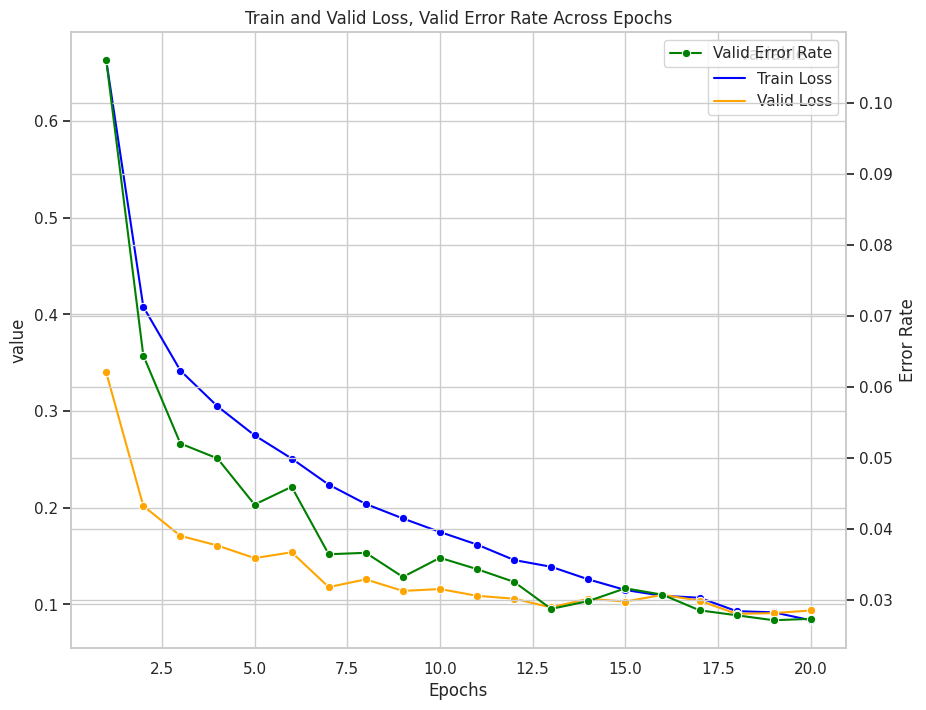

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the train_log.txt file
log_file_path = "results/xvect_fbanks_12/1986/train_log.txt"

# Open the train_log.txt file and read its contents
with open(log_file_path, "r") as file:
    log_data = file.read()

# Use regular expressions to extract the data for train loss, valid loss, and valid ErrorRate
data = []
pattern = re.compile(r"epoch: (\d+), .* - train loss: (\d+\.\d+e[-+]\d+) - valid loss: (\d+\.\d+e[-+]\d+), valid ErrorRate: (\d+\.\d+e[-+]\d+)")
matches = pattern.findall(log_data)

for match in matches:
    epoch = int(match[0])
    train_loss = float(match[1])
    valid_loss = float(match[2])
    valid_error_rate = float(match[3])
    data.append((epoch, train_loss, valid_loss, valid_error_rate))

# Create a DataFrame
df = pd.DataFrame(data, columns=["Epochs", "Train Loss", "Valid Loss", "Valid Error Rate"])

# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Plot train and valid loss
sns.lineplot(x="Epochs", y="value", hue="variable",
             data=pd.melt(df, id_vars=["Epochs"], value_vars=["Train Loss", "Valid Loss"]),
             marker="o", palette={"Train Loss": "blue", "Valid Loss": "orange"})

# Add secondary y-axis for Valid Error Rate
ax2 = plt.gca().twinx()
sns.lineplot(x="Epochs", y="Valid Error Rate", data=df, color="green", ax=ax2, marker="o", label="Valid Error Rate")

# Set plot labels and legend
plt.title("Train and Valid Loss, Valid Error Rate Across Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax2.set_ylabel("Error Rate")
plt.legend(loc="upper right")

plt.show()


## Wav2Vec2

### Hparams file V1
 Hparams file that implements **Wav2Vec2** ssl model and a simple **linear MLP** model with freeze_ssl : false and  freeze_ssl_conv : true


In [ ]:
%%file wav_to_vec_2.yaml
# ################################
# Model: Classification with SpeechBrain Implementaion of Wav2vec with an MLP
# Authors: Hwidong Na,Mirco Ravanelli & David Raby-Pepin
#          Script adapted by Ajay Ramasubramanian
# ################################
# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/wav_2_vec_<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/wav2vec2-base
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 20
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001
sample_rate: 16000
shuffle: True
encoder_dim: 768

######################### SSL Model parameters ##################################
#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>


# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss


opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting wav_to_vec_2.yaml


### Hparams file V2
Hparams file tha implements **Wav2Vec2** ssl model with a simple **linear MLP** model with freeze_sll : **True** and  freeze_ssl_conv : **True**

In [ ]:
%%file wav_to_vec_2_freeze.yaml
# ################################
# Model: Classification with SpeechBrain Implementaion of Wav2vec with an MLP
# Authors: Hwidong Na & Mirco Ravanelli & David Raby-Pepin 2021
#          Script adapted by Ajay Ramasubramanian
# ################################
# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/wav_2_vec_freeze<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/wav2vec2-base
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 1
batch_size: 4
lr: 0.0001
lr_ssl: 0.00001
sample_rate: 16000
shuffle: True

######################### SSL Model parameters ##################################

#freeze all ssl
freeze_ssl: True
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 768
# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting wav_to_vec_2_freeze.yaml


### Train file without data augmentation

In [ ]:
%%file train_wav_2_vec.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    * David Raby-Pepin 2021
    Script adapted by Ajay Ramasubramanian
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
"""
    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        # Feature extraction and normalization
        feats = self.modules.ssl_model(wavs, lens)
        feats = self.hparams.avg_pool(feats, lens)
        # print(f' \n\nfeats before flatten: {feats.shape} ')

        feats= feats.view(feats.shape[0],-1)
        # print(f' \n\nfeats after flatten: {feats.shape} ')

        feats = self.modules.output_mlp(feats)
        feats = self.hparams.log_softmax(feats)
        # print(f'\n\n feature size : {feats.shape}')


        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
        # print(f'command shape :{command.shape}')
        # print(f'/n/n predictions shpae :{predictions.shape} and lens : {lens.shape}')
        # Concatenate labels (due to data augmentation)
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
        "Initializes the ssl optimizer and model optimizer"
        self.ssl_optimizer = self.hparams.ssl_opt_class(
        self.modules.ssl_model.parameters()
        )
        self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

        if self.checkpointer is not None:
            self.checkpointer.add_recoverable(
            "ssl_opt", self.ssl_optimizer
            )
        self.checkpointer.add_recoverable("optimizer", self.optimizer)

        self.optimizers_dict = {
        "model_optimizer": self.optimizer,
        "ssl_optimizer": self.ssl_optimizer,
        }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_wav_2_vec.py


### V1 Result

In [ ]:
# !rm -rf results/xvect_v12
!python train_wav_2_vec.py wav_to_vec_2.yaml --data_folder=/path_to_/GSC


This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
/usr/local/lib/python3.9/dist-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
speechbrain.lobes.models.huggingface_transformers.wav2vec2 - wav2vec 2.0 feature extractor is frozen.
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/wav_2_vec_12/1986
prepare_GSC - Extracting speech_commands_v0.02.tar.gz...
/path_to_/GSC/nois

### Graphs

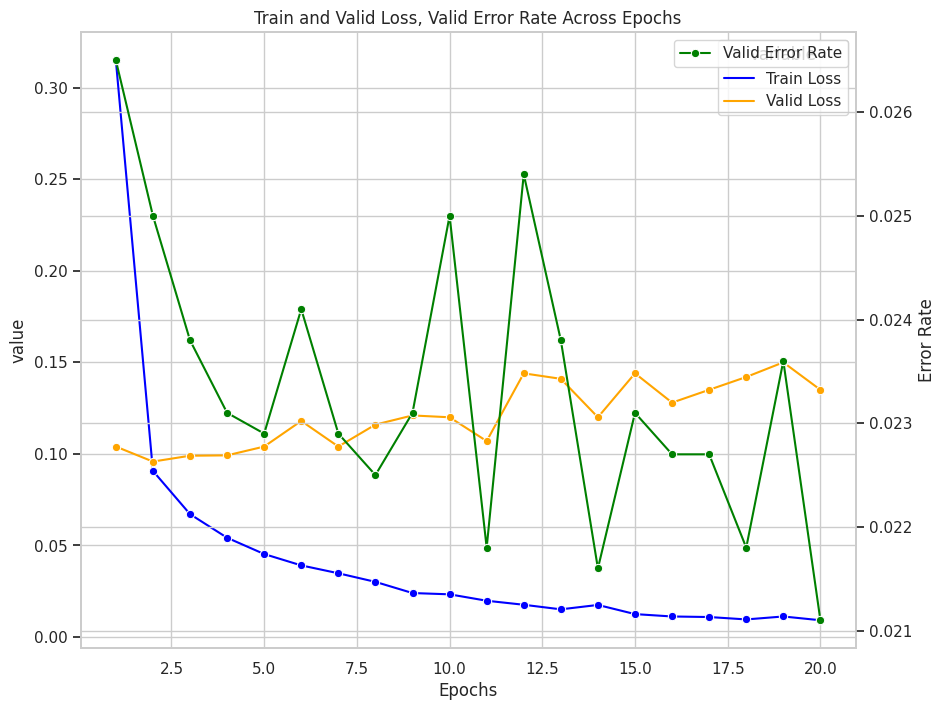

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the train_log.txt file
log_file_path = "results/wav_2_vec_12/1986/train_log.txt"

# Open the train_log.txt file and read its contents
with open(log_file_path, "r") as file:
    log_data = file.read()

# Use regular expressions to extract the data for train loss, valid loss, and valid ErrorRate
data = []
pattern = re.compile(r"epoch: (\d+), .* - train loss: (\d+\.\d+e[-+]\d+) - valid loss: (\d+\.\d+e[-+]\d+), valid ErrorRate: (\d+\.\d+e[-+]\d+)")
matches = pattern.findall(log_data)

for match in matches:
    epoch = int(match[0])
    train_loss = float(match[1])
    valid_loss = float(match[2])
    valid_error_rate = float(match[3])
    data.append((epoch, train_loss, valid_loss, valid_error_rate))

# Create a DataFrame
df = pd.DataFrame(data, columns=["Epochs", "Train Loss", "Valid Loss", "Valid Error Rate"])

# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Plot train and valid loss
sns.lineplot(x="Epochs", y="value", hue="variable",
             data=pd.melt(df, id_vars=["Epochs"], value_vars=["Train Loss", "Valid Loss"]),
             marker="o", palette={"Train Loss": "blue", "Valid Loss": "orange"})

# Add secondary y-axis for Valid Error Rate
ax2 = plt.gca().twinx()
sns.lineplot(x="Epochs", y="Valid Error Rate", data=df, color="green", ax=ax2, marker="o", label="Valid Error Rate")

# Set plot labels and legend
plt.title("Train and Valid Loss, Valid Error Rate Across Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax2.set_ylabel("Error Rate")
plt.legend(loc="upper right")

plt.show()


### V2 Result's

In [ ]:

!python train_wav_2_vec.py wav_to_vec_2_freeze.yaml --data_folder= /path_to_/GSC

## **Hubert**


### Hparams V1
Hparams file that implements **Hubert model** with a **simple linear MLP** model with freeze_ssl: false and  freeze_ssl_conv: True<br>
**HuBERT (Hybrid Universal BERT)** is a model developed by Facebook AI for speech recognition tasks. It combines elements of convolutional neural networks (CNNs) and transformer-based architectures like BERT. HuBERT has been pre-trained on large-scale unlabeled audio data using self-supervised learning techniques, making it adept at capturing speech representations.
This YAML file contains hyperparameters for training a model, particularly for speech recognition tasks using the HuBERT model. Here's a brief overview:

Basic Parameters:

- seed: Random seed for reproducibility.
- number_of_commands: Number of commands to recognize.
- output_folder: Directory to save results.
- save_folder: Directory to save model checkpoints.
- train_log: Path to the training log file.

**Model Configuration:**

- *sslmodel_hub*: Pre-trained SSL model (HuBERT in this case).
- *freeze_ssl*: Whether to freeze SSL model during training.
- *freeze_ssl_conv*: Whether to freeze the convolutional part of the SSL model.
- *encoder_dim*: Dimensionality of the encoder.
- *out_n_neurons*: Number of output neurons (classes).

Components of the model architecture

- *ssl_model*
- *avg_pool*
- *output_mlp*
- *log_softmax*

**Data Augmentation:**
URLs for noise and room impulse response datasets.
Configuration for adding noise and reverberation to input signals.
Parameters for frequency and time domain dropout augmentations.

**Training Parameters:**

- number_of_epochs
- batch_size
- lr
- lr_ssl: Training settings.
- sample_rate
- shuffle
- num_workers: Dataset processing settings.

**Logging and Checkpoints:**

- train_logger: Logger for training progress.
- error_stats: Metric for evaluating training performance.
- checkpointer: Component for saving and restoring model checkpoints.

**Dataset Preparation:**
Instructions for downloading and preparing noisy sequences and room impulse responses for augmentation.

In [ ]:
%%file hubert.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/hubert<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/hubert-base-ls960
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 20
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 16000
shuffle: True

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 768
# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.hubert.HuBERT
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting hubert.yaml


### Hparams V2
Hparams file which implements Hubert model with a simple linear MLP Hparams model with freeze_ssl: True and  freeze_ssl_conv: True


In [ ]:
%%file hubert_freeze.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/hubert<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/hubert-base-ls960
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 20
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 16000
shuffle: True

#freeze all ssl
freeze_ssl: True
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 768
# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.hubert.HuBERT
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Writing hubert_freeze.yaml


### Train file without data augmentation

In [ ]:
%%file train_wav_2_vec.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    * David Raby-Pepin 2021
    Script adapted by Ajay Ramasubramanian 2024
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
"""

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        # Add waveform augmentation if specified.
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     wavs, lens = self.hparams.wav_augment(wavs, lens)

        # else:
        # Feature extraction and normalization
        feats = self.modules.ssl_model(wavs, lens)
        feats = self.hparams.avg_pool(feats, lens)
        # print(f' \n\nfeats before flatten: {feats.shape} ')

        feats= feats.view(feats.shape[0],-1)
        # print(f' \n\nfeats after flatten: {feats.shape} ')

        feats = self.modules.output_mlp(feats)
        feats = self.hparams.log_softmax(feats)
        # print(f'\n\n feature size : {feats.shape}')


        # # Ecapa model uses softmax outside of its classifer
        # if "softmax" in self.modules.keys():
        #     outputs = self.modules.softmax(outputs)

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
        # print(f'command shape :{command.shape}')
        # print(f'/n/n predictions shpae :{predictions.shape} and lens : {lens.shape}')
        # Concatenate labels (due to data augmentation)
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_wav_2_vec.py


####  Results

In [ ]:
!python train_wav_2_vec.py hubert.yaml --data_folder=/path_to_/GSC

This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
speechbrain.lobes.models.huggingface_transformers.wav2vec2 - wav2vec 2.0 feature extractor is frozen.
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/hubert12/1986
prepare_GSC - Extracting speech_commands_v0.02.tar.gz...
/path_to_/GSC/noise/data.zip exists. Skipping download
/path_to_/GSC/rir/data.zip exists. Skipping download
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - Gradscaler enabled: F

## WavLM Model



### Hparams V1
Hparams file which implements WavLM model with a simple liner MLP model with freeze_ssl: false and frezee_ssl_conv: True <br>
WavLM represents a powerful approach to language modeling that operates directly on raw audio signals, enabling it to capture rich information present in the audio domain. Its self-supervised learning paradigm and fine-tuning capabilities make it perfect candidate for Keyword Spotting application.
   
**Basic Parameters**:
- seed: Seed used for random number generation.
- number_of_commands: Number of classes or commands for the task.
- output_folder: Output folder path where results will be stored.
- save_folder: Folder path for saving model checkpoints.
- train_log: File path for logging training progress.
    
**SSL Model Configuration**:
- sslmodel_hub: URL or name of the SSL (self-supervised learning) model.
- sslmodel_folder: Folder path for saving SSL model checkpoints.
    
**Data and Augmentation**:
URLs for downloading noise and room impulse response (RIR) datasets.
Paths for storing noisy sequences and RIR data for augmentation.
File paths for train, validation, and test data annotations.
Percentage of unknown and silence examples to include in the dataset.
Settings for data augmentation such as noise addition, reverberation, frequency drop, and time drop.

**Training Parameters**:
- Number of epochs, batch size, learning rate, and sample rate.
- Configuration for SSL model freezing and feature extractor freezing.
- Number of classes (commands)
- number of workers for data loading
-encoder dimension.
    
**Model Architecture**:
    
- Configuration for the SSL model
- average pooling
- output MLP
- log softmax activation.
- Epoch counter configuration for tracking training progress.

**Cost and Optimization**:
    
Configuration for computing cost, optimization class, learning rate annealing, and logging/checkpoints.
Logging and Checkpoints:
Configuration for training logger, error statistics, and checkpointer for saving/loading model checkpoints.

In [ ]:
%%file wavlm.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/wavlm<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: microsoft/wavlm-large
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 10
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 16000
shuffle: True

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 1024
# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wavlm.WavLM
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>

        counter: !ref <epoch_counter>

Overwriting wavlm.yaml


### Hparams V2
Hparams file which implements WavLM model with a simple liner MLP model <br>with freeze_ssl: True and frezee_ssl_conv: True

In [ ]:
%%file wavlm.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/wavlm<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: microsoft/wavlm-large
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 5
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 16000
shuffle: True

#freeze all ssl
freeze_ssl: True
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 1024
# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wavlm.WavLM
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Writing wavlm.yaml


### we make use of the same train file as wav_2_vec train file

### V1 Results

In [ ]:
!python train_wav_2_vec.py wavlm.yaml --data_folder=/path_to_/GSC

This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
speechbrain.lobes.models.huggingface_transformers.wav2vec2 - wav2vec 2.0 feature extractor is frozen.
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/wavlm12/1986
prepare_GSC - Extracting speech_commands_v0.02.tar.gz...
noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1: 569MB [00:06, 83.7MB/s]        
Extracting /path_to_/GSC/noise/data.zip to /path_to_/GSC/noise
RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1: 246MB [00:02, 90.9MB/s]          
Extracting /path_to_/GSC/rir/data.zip to /path_to_/GSC/rir
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. Thi

# Discrete features

## EncoDec


###  Hparams-simple MLP
EncoDec model with a simple linear MLP Hparams file

In [5]:
%%file EncoDec.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref /results/enco_dec_mlp_<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/encodec_24khz
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 20
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 24000
shuffle: True

#freeze all ssl
freeze_ssl: True
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 1200
# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.encodec.Encodec
    source: !ref <sslmodel_hub>
    sample_rate: !ref <sample_rate>
    bandwidth: 12.0
    freeze: !ref <freeze_ssl>
    flat_embeddings: False
    renorm_embeddings: True
    # freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Writing EncoDec.yaml


### Train file - simple MLP

In [6]:
%%file train_enco_dec.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    Script adapted by Ajay Ramasubramanian 
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
import torchaudio
import librosa

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        # Add waveform augmentation if specified.
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     wavs, lens = self.hparams.wav_augment(wavs, lens)
        # print(f' \n computefeature type :{type(self.modules.compute_features)}')
    
        # else:
            # Feature extraction and normalization
        feats,_= self.modules.ssl_model.encode(wavs, lens)
        # print(f'/n feats dtype : {type(feats)}')
        # print(f'\n\n feats  : {feats}')
        feats= feats.float()
        feats = self.hparams.mean_var_norm(feats, lens)
        # print(f' \n\nfeats before flatten: {feats.shape} ')

        batch,_,_=feats.shape
        feats = feats.reshape(batch, -1)
        # print(f' \n\nfeats after flatten: {feats.shape} ')

        feats = self.modules.output_mlp(feats)

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
        # print(f'command shape :{command.shape}')
        # print(f'/n/n predictions shpae :{predictions.shape} and lens : {lens.shape}')
        # Concatenate labels (due to data augmentation)
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
    
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration, target_sr=24000):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        # print(f'sig before resampling{sig},\n shape {sig.shape}')
        if fs != target_sr:
          sig = librosa.resample(sig.numpy(), orig_sr=fs, target_sr=target_sr)
          sig = torch.tensor(sig)
        # print(f'sig after resampling{sig},\n shape {sig.shape}')
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_enco_dec.py


#### Results

In [8]:
# !rm -rf /content/results/enco_dec12/1986
!python train_enco_dec.py EncoDec.yaml --data_folder=/path_to_/GSC

This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
/usr/local/lib/python3.9/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64)

### Hparams - LSTM
 Encodec model with LSTM Hparams file

In [4]:
%%file EncoDec_lstm.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/enco_dec_LSTM_Aug_<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task

# This allow you to have ~4% improvment
sslmodel_hub: facebook/encodec_24khz
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 20
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 24000
shuffle: True

#freeze all ssl
freeze_ssl: True
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words
input_shape: 1024
num_workers: 4
num_clusters: 1024
num_codebooks: 16
embedding_dim: 128
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 1024
# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.encodec.Encodec
    source: !ref <sslmodel_hub>
    sample_rate: !ref <sample_rate>
    bandwidth: 12.0
    freeze: !ref <freeze_ssl>
    flat_embeddings: False
    renorm_embeddings: True
    # freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

discrete_embedding_layer: !new:custom_model.Discrete_EmbeddingLayer
   num_codebooks: !ref <num_codebooks>
   vocab_size: !ref <num_clusters>
   emb_dim: !ref <encoder_dim>

attention_mlp: !new:custom_model.AttentionMLP
   input_dim: !ref <encoder_dim>
   hidden_dim: !ref <encoder_dim>


lstm: !new:speechbrain.nnet.RNN.LSTM
    input_size: !ref <input_shape>  # Define the input size here
    hidden_size: 512  # Define the hidden size of the LSTM
    num_layers: 3  # Define the number of LSTM layers
    bidirectional: False  # Set to True if you want a bidirectional LSTM
    dropout: 0.5  # Define the dropout probability

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

ctc_lin: !new:speechbrain.nnet.linear.Linear
   input_size: 512
   n_neurons: !ref <out_n_neurons>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    discrete_embedding_layer: !ref <discrete_embedding_layer>
    attention_mlp: !ref <attention_mlp>
    lstm: !ref <lstm>
    ctc_lin: !ref <ctc_lin>

model: !new:torch.nn.ModuleList
    - [!ref <ssl_model>, !ref <attention_mlp>, !ref <discrete_embedding_layer>, !ref <lstm>, !ref <ctc_lin>]


# Cost + optimization
# ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
#    blank_index: 0
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting EncoDec_lstm.yaml


### Train file - LSTM

In [13]:
%%file train_enco_dec_lstm.py
# Set the CUDA_LAUNCH_BLOCKING environment variable


#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    * David Raby-Pepin 2021
    Script adapted by Ajay Ramasubramanian 2024
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
import torchaudio
import librosa

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig
        # print(f'wavs length: {wavs.shape}')
        # Add waveform augmentation if specified.
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     wavs, lens = self.hparams.wav_augment(wavs, lens)
        # print(f' \n computefeature type :{type(self.modules.compute_features)}')
    
            # Feature extraction and normalization
        feats,_= self.modules.ssl_model.encode(wavs, lens)
        # /print(f'lens: {lens}')
        embeddings = self.modules.discrete_embedding_layer(feats)
        # print(f'embedding shape: { embeddings.shape}')
        att_w = self.modules.attention_mlp(embeddings)
        # print(f'att_w shape: { att_w.shape}')
        feats = torch.matmul(att_w.transpose(2, -1), embeddings).squeeze(-2)
        # print(f'feats size before LSTM : {feats.shape}')
       
        lstm_feats, _ = self.modules.lstm(feats)
        # print(f' \n\nLSTM feats before flatten: {lstm_feats.shape} ')

        lstm_feats= self.hparams.avg_pool(lstm_feats)

    # Reshape LSTM output
        batch_size,_,_ = lstm_feats.shape
        lstm_feats = lstm_feats.reshape(batch_size,-1)
        # lstm_feats= lstm_feats[0]

        # print(f' \n\nfeats after flatten: {feats.shape} ')

        feats = self.modules.ctc_lin(lstm_feats)
        feats = self.hparams.log_softmax(feats)
        # print(f'\n\n feature size : {feats.shape}')

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, command_lens = batch.command_encoded
        # Concatenate labels (due to data augmentation)
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration, target_sr=24000):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        # print(f'sig before resampling{sig},\n shape {sig.shape}')
        if fs != target_sr:
          sig = librosa.resample(sig.numpy(), orig_sr=fs, target_sr=target_sr)
          sig = torch.tensor(sig)
        # print(f'sig after resampling{sig},\n shape {sig.shape}')
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_enco_dec_lstm.py


### Train file -LSTM(with augumentation)

In [6]:
%%file train_enco_dec_lstm_with_aug.py
# Set the CUDA_LAUNCH_BLOCKING environment variable


#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    * David Raby-Pepin 2021
    Script adapted by Ajay Ramasubramanian 2024
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
import torchaudio
import librosa

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig
    
        # Add waveform augmentation if specified.
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            wavs, lens = self.hparams.wav_augment(wavs, lens)
        
        # Feature extraction and normalization
        feats,_= self.modules.ssl_model.encode(wavs, lens)
        # /print(f'lens: {lens}')
        embeddings = self.modules.discrete_embedding_layer(feats)
        # print(f'embedding shape: { embeddings.shape}')
        att_w = self.modules.attention_mlp(embeddings)
        # print(f'att_w shape: { att_w.shape}')
        feats = torch.matmul(att_w.transpose(2, -1), embeddings).squeeze(-2)
        # print(f'feats size before LSTM : {feats.shape}')
        lstm_feats, _ = self.modules.lstm(feats)
        lstm_feats= self.hparams.avg_pool(lstm_feats)
        
        # Reshape LSTM output
        batch_size,_,_ = lstm_feats.shape
        lstm_feats = lstm_feats.reshape(batch_size,-1)

        feats = self.modules.ctc_lin(lstm_feats)
        feats = self.hparams.log_softmax(feats)

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, command_lens = batch.command_encoded

        # Concatenate labels (due to data augmentation)
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)


        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration, target_sr=24000):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        # print(f'sig before resampling{sig},\n shape {sig.shape}')
        if fs != target_sr:
          sig = librosa.resample(sig.numpy(), orig_sr=fs, target_sr=target_sr)
          sig = torch.tensor(sig)
        # print(f'sig after resampling{sig},\n shape {sig.shape}')
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Writing train_enco_dec_lstm_with_aug.py


#### Results

##### Without augmentation

In [16]:
# !rm -rf /content/results/enco_dec12/1986
!python train_enco_dec_lstm.py EncoDec_lstm.yaml --data_folder = /path_to_/GSC/


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/usr/local/lib/python3.11/dist-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)
speechbrain.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

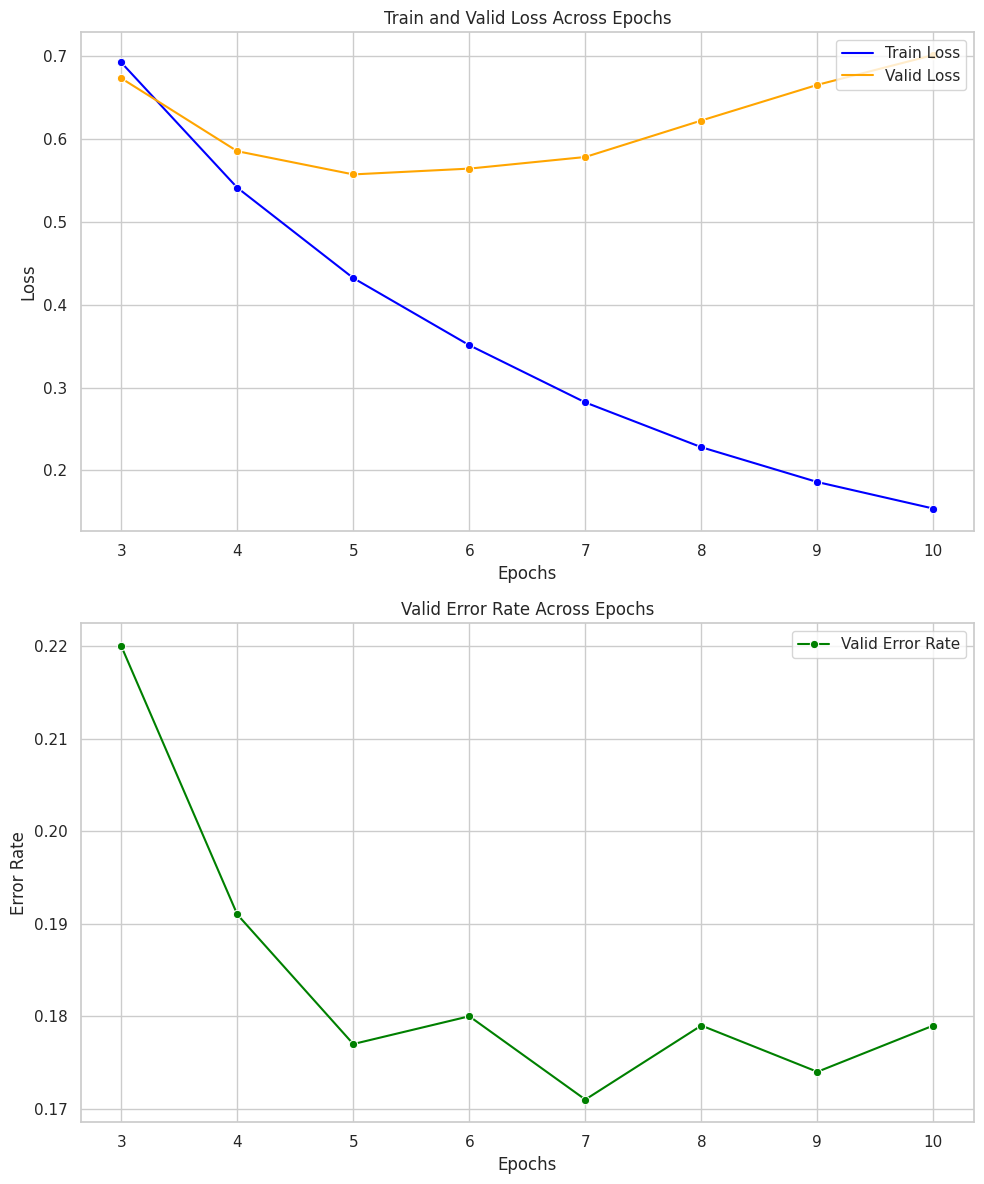

In [4]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the train_log.txt file
log_file_path = "LSTM without augmentation 10 epochs train_log.txt"

# Open the train_log.txt file and read its contents
with open(log_file_path, "r") as file:
    log_data = file.read()

# Use regular expressions to extract the data for train loss, valid loss, and valid ErrorRate
data = []
pattern = re.compile(r"epoch: (\d+), .* - train loss: (\d+\.\d+e[-+]\d+) - valid loss: (\d+\.\d+e[-+]\d+), valid ErrorRate: (\d+\.\d+e[-+]\d+)")
matches = pattern.findall(log_data)

for match in matches:
    epoch = int(match[0])
    train_loss = float(match[1])
    valid_loss = float(match[2])
    valid_error_rate = float(match[3])
    data.append((epoch, train_loss, valid_loss, valid_error_rate))

# Create a DataFrame
df = pd.DataFrame(data, columns=["Epochs", "Train Loss", "Valid Loss", "Valid Error Rate"])

# Plot using Seaborn
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot train and valid loss in the first subplot
sns.lineplot(ax=axes[0], x="Epochs", y="value", hue="variable",
             data=pd.melt(df, id_vars=["Epochs"], value_vars=["Train Loss", "Valid Loss"]),
             marker="o", palette={"Train Loss": "blue", "Valid Loss": "orange"})

# Set labels and legend for the first subplot
axes[0].set_title("Train and Valid Loss Across Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend(loc="upper right")

# Plot valid error rate in the second subplot
sns.lineplot(ax=axes[1], x="Epochs", y="Valid Error Rate", data=df, color="green", marker="o", label="Valid Error Rate")

# Set labels and legend for the second subplot
axes[1].set_title("Valid Error Rate Across Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Error Rate")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


##### With Augmentation


In [4]:
# !rm -rf /content/results/enco_dec12/1986
!python train_enco_dec_lstm_with_aug.py EncoDec_lstm.yaml --data_folder = /path_to_/GSC/


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/usr/local/lib/python3.11/dist-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)
speechbrain.

#### Graph

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

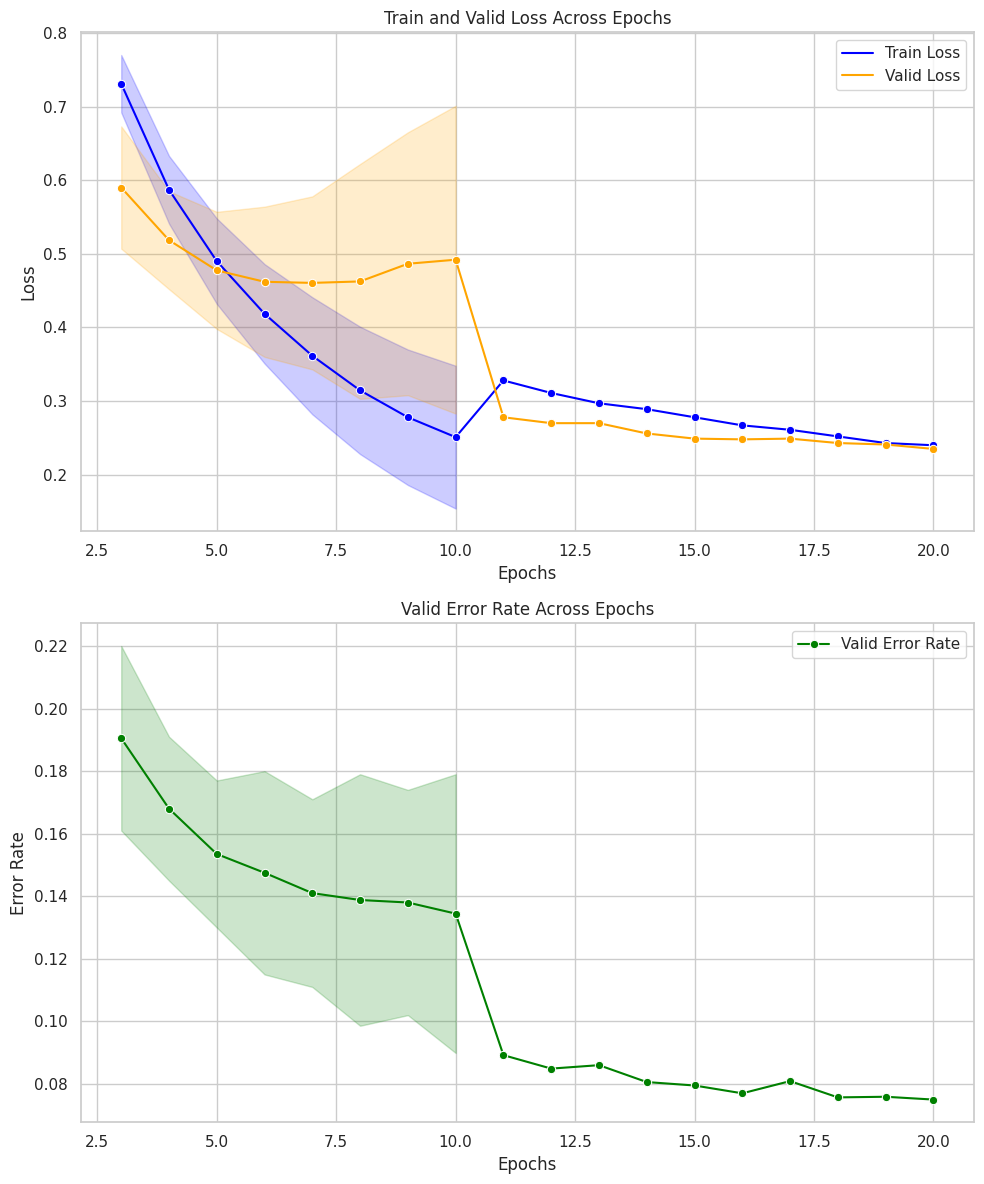

In [6]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the train_log.txt file
log_file_path = "results/enco_dec_LSTM_Aug_12/1986/train_log.txt"

# Open the train_log.txt file and read its contents
with open(log_file_path, "r") as file:
    log_data = file.read()

# Use regular expressions to extract the data for train loss, valid loss, and valid ErrorRate
data = []
pattern = re.compile(r"epoch: (\d+), .* - train loss: (\d+\.\d+e[-+]\d+) - valid loss: (\d+\.\d+e[-+]\d+), valid ErrorRate: (\d+\.\d+e[-+]\d+)")
matches = pattern.findall(log_data)

for match in matches:
    epoch = int(match[0])
    train_loss = float(match[1])
    valid_loss = float(match[2])
    valid_error_rate = float(match[3])
    data.append((epoch, train_loss, valid_loss, valid_error_rate))

# Create a DataFrame
df = pd.DataFrame(data, columns=["Epochs", "Train Loss", "Valid Loss", "Valid Error Rate"])

# Plot using Seaborn
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot train and valid loss in the first subplot
sns.lineplot(ax=axes[0], x="Epochs", y="value", hue="variable",
             data=pd.melt(df, id_vars=["Epochs"], value_vars=["Train Loss", "Valid Loss"]),
             marker="o", palette={"Train Loss": "blue", "Valid Loss": "orange"})

# Set labels and legend for the first subplot
axes[0].set_title("Train and Valid Loss Across Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend(loc="upper right")

# Plot valid error rate in the second subplot
sns.lineplot(ax=axes[1], x="Epochs", y="Valid Error Rate", data=df, color="green", marker="o", label="Valid Error Rate")

# Set labels and legend for the second subplot
axes[1].set_title("Valid Error Rate Across Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Error Rate")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


### Hparams - Conformer

In [14]:
%%file EncoDec_conformer.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/enco_dec_conformer_<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task

# This allow you to have ~4% improvment
sslmodel_hub: facebook/encodec_24khz
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 20
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 24000
shuffle: True

#freeze all ssl
freeze_ssl: True
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words
input_shape: 1024
num_workers: 4
num_clusters: 1024
num_codebooks: 16
embedding_dim: 128
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 1024
# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.encodec.Encodec
    source: !ref <sslmodel_hub>
    sample_rate: !ref <sample_rate>
    bandwidth: 12.0
    freeze: !ref <freeze_ssl>
    flat_embeddings: False
    renorm_embeddings: True
    # freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

discrete_embedding_layer: !new:custom_model.Discrete_EmbeddingLayer
   num_codebooks: !ref <num_codebooks>
   vocab_size: !ref <num_clusters>
   emb_dim: !ref <encoder_dim>

attention_mlp: !new:custom_model.AttentionMLP
   input_dim: !ref <encoder_dim>
   hidden_dim: !ref <encoder_dim>


enc: !new:speechbrain.lobes.models.transformer.Conformer.ConformerEncoder
    num_layers: 1
    nhead: 8
    d_ffn: 1024
    attention_type: 'regularMHA'
    # input_shape: [null, null, !ref <input_shape>]
    d_model: 1024
    
avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

ctc_lin: !new:speechbrain.nnet.linear.Linear
   input_size: 1024
   n_neurons: !ref <out_n_neurons>


log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    discrete_embedding_layer: !ref <discrete_embedding_layer>
    attention_mlp: !ref <attention_mlp>
    enc: !ref <enc>
    ctc_lin: !ref <ctc_lin>

model: !new:torch.nn.ModuleList
    - [!ref <ssl_model>, !ref <attention_mlp>, !ref <discrete_embedding_layer>, !ref <enc>, !ref <ctc_lin>]


# Cost + optimization
# ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
#    blank_index: 0
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting EncoDec_conformer.yaml


### Train file - Conformer

In [15]:
%%file train_encodec_conformer.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    * David Raby-Pepin 2021
    Script adapted by Ajay Ramasubramanian 2024
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
import torchaudio
import librosa

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        # Add waveform augmentation if specified.
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            wavs, lens = self.hparams.wav_augment(wavs, lens)
        # print(f' \n computefeature type :{type(self.modules.compute_features)}')
        
        # Feature extraction and normalization
        feats,_ = self.modules.ssl_model(wavs, lens)
        # print(f'/n feats dtype : {type(feats)}')
        embeddings = self.modules.discrete_embedding_layer(feats)
        # print(f'embedding shape: { embeddings.shape}')
        att_w = self.modules.attention_mlp(embeddings)
        # print(f'att_w shape: { att_w.shape}')
        feats = torch.matmul(att_w.transpose(2, -1), embeddings).squeeze(-2)
        # print(f'\n\n feats  : {feats} and \n\nfeats shape: {feats.shape}')
        enc_feats,_ = self.modules.enc(feats)
        enc_feats = self.hparams.avg_pool(enc_feats, lens)
        # print(f'\n\n enc_feats : {enc_feats} \n\n enc_feat size : {enc_feats.shape} ')
        batch,_,_=enc_feats.shape
        enc_feats = enc_feats.reshape(batch, -1)
        # crdnn_feats = crdnn_feats.view(crdnn_feats.size(0), -1)
        feats = self.modules.ctc_lin(enc_feats)
        feats = self.hparams.log_softmax(feats)
        # print(f'\n\n feature size : {feats.shape}')

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
       
        # Concatenate labels (due to data augmentation)
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration,target_sr=24000):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        if fs != target_sr:
          sig = librosa.resample(sig.numpy(), orig_sr=fs, target_sr=target_sr)
          sig = torch.tensor(sig)

        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_encodec_conformer.py


#### Results
##### With Augumentation

In [ ]:
!python train_encodec_conformer.py EncoDec_conformer.yaml --data_folder = /path_to_/GSC/

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/usr/local/lib/python3.11/dist-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)
speechbrain.

#### Graph

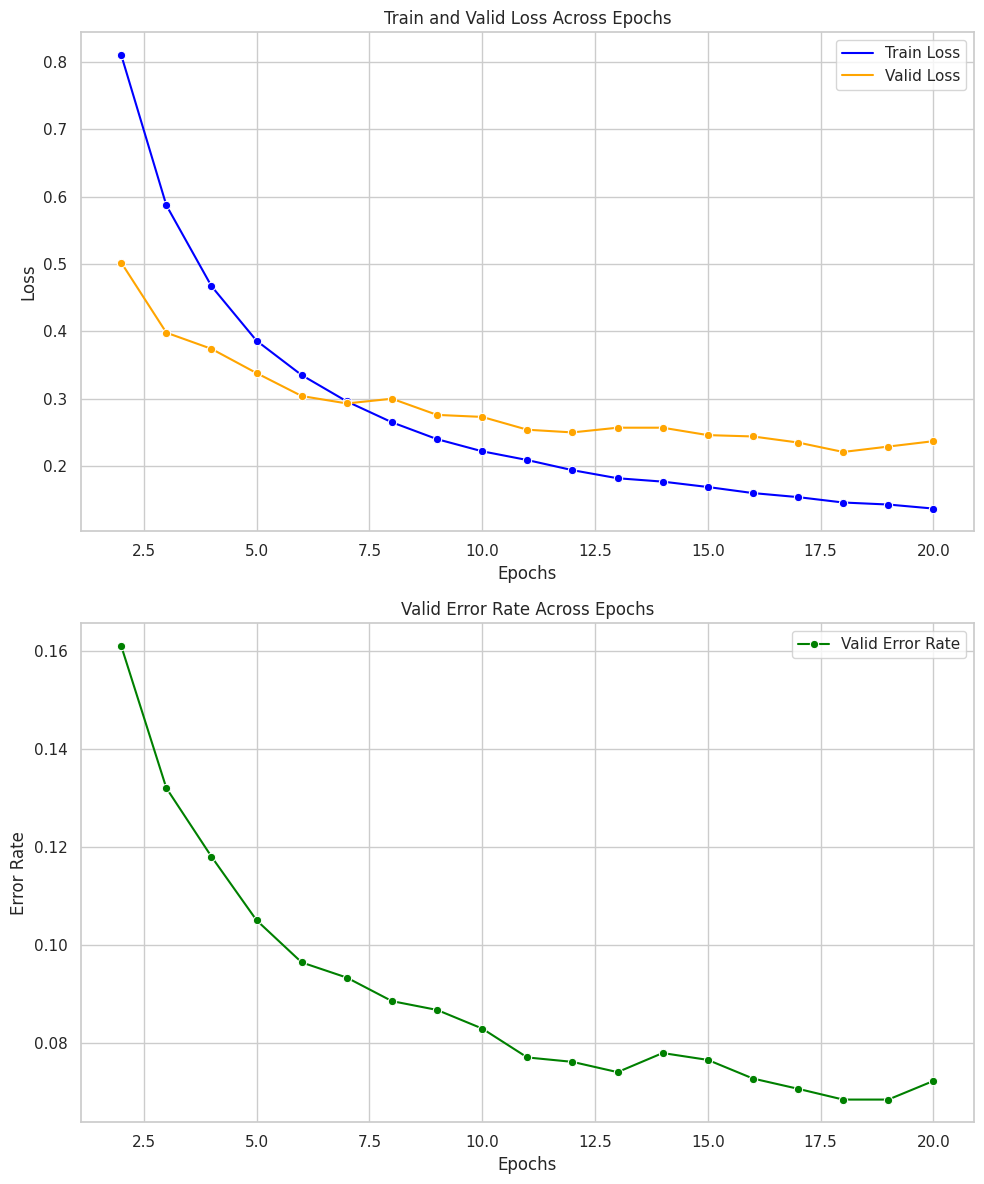

In [2]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Path to the train_log.txt file
log_file_path = "results/enco_dec_conformer_12/1986/train_log.txt"

# Open the train_log.txt file and read its contents
with open(log_file_path, "r") as file:
    log_data = file.read()

# Use regular expressions to extract the data for train loss, valid loss, and valid ErrorRate
data = []
pattern = re.compile(r"epoch: (\d+), .* - train loss: (\d+\.\d+e[-+]\d+) - valid loss: (\d+\.\d+e[-+]\d+), valid ErrorRate: (\d+\.\d+e[-+]\d+)")
matches = pattern.findall(log_data)

for match in matches:
    epoch = int(match[0])
    train_loss = float(match[1])
    valid_loss = float(match[2])
    valid_error_rate = float(match[3])
    data.append((epoch, train_loss, valid_loss, valid_error_rate))

# Create a DataFrame
df = pd.DataFrame(data, columns=["Epochs", "Train Loss", "Valid Loss", "Valid Error Rate"])

# Plot using Seaborn
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot train and valid loss in the first subplot
sns.lineplot(ax=axes[0], x="Epochs", y="value", hue="variable",
             data=pd.melt(df, id_vars=["Epochs"], value_vars=["Train Loss", "Valid Loss"]),
             marker="o", palette={"Train Loss": "blue", "Valid Loss": "orange"})

# Set labels and legend for the first subplot
axes[0].set_title("Train and Valid Loss Across Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend(loc="upper right")

# Plot valid error rate in the second subplot
sns.lineplot(ax=axes[1], x="Epochs", y="Valid Error Rate", data=df, color="green", marker="o", label="Valid Error Rate")

# Set labels and legend for the second subplot
axes[1].set_title("Valid Error Rate Across Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Error Rate")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


### Hparams - CRDNN
Hparams file Encodec with a CRDNN model

In [10]:
%%file EncoDec_CRDNN.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/enco_dec_CRDNN<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/encodec_24khz
sslmodel_folder: !ref <save_folder>/ssl_checkpoint



# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 20
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001
sample_rate: 24000
shuffle: True

    
#freeze all ssl
freeze_ssl: True
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words
input_shape: 1024
num_workers: 4
num_clusters: 1024
num_codebooks: 16
embedding_dim: 128
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>


encoder_dim: 1024
# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.encodec.Encodec
    source: !ref <sslmodel_hub>
    sample_rate: !ref <sample_rate>
    bandwidth: 12.0
    freeze: !ref <freeze_ssl>
    flat_embeddings: False
    renorm_embeddings: True
    # freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>


mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False
#CRDNN Encoder Parameters
dnn_neurons: 512
activation: !name:torch.nn.LeakyReLU
# CRDNN Encoder
enc: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, !ref <encoder_dim>]
    activation: !ref <activation>
    dropout: 0.15
    cnn_blocks: 2
    cnn_channels: (128, 256)
    cnn_kernelsize: (3, 3)
    inter_layer_pooling_size: (2, 2)
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: 4
    rnn_class: !name:speechbrain.nnet.RNN.LSTM
    rnn_layers: 2
    rnn_neurons: 1024
    rnn_bidirectional: True
    rnn_re_init: True
    dnn_blocks: 2
    dnn_neurons: !ref <dnn_neurons>
    use_rnnp: False
    
discrete_embedding_layer: !new:custom_model.Discrete_EmbeddingLayer
   num_codebooks: !ref <num_codebooks>
   vocab_size: !ref <num_clusters>
   emb_dim: !ref <encoder_dim>

attention_mlp: !new:custom_model.AttentionMLP
   input_dim: !ref <encoder_dim>
   hidden_dim: !ref <encoder_dim>

# Output Linear Layer
output_mlp: !new:speechbrain.nnet.linear.Linear
   input_size: 512
   n_neurons: !ref <out_n_neurons>


log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]


modules:
    ssl_model: !ref <ssl_model>
    discrete_embedding_layer: !ref <discrete_embedding_layer>
    attention_mlp: !ref <attention_mlp>
    enc: !ref <enc>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <ssl_model>, !ref <enc> ,!ref <discrete_embedding_layer>, !ref <attention_mlp>,!ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Writing EncoDec_CRDNN.yaml


### Train file - CRDNN
 Train file for Encodec with CRDNN model

In [4]:
%%file train_enco_dec_crdnn.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
     *David Raby-Pepin 2021
    Script adapted by 
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
import torchaudio
import librosa

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        # Add waveform augmentation if specified.
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            wavs, lens = self.hparams.wav_augment(wavs, lens)
        # print(f' \n computefeature type :{type(self.modules.compute_features)}')
        # if   isinstance(
        #     self.modules.compute_features, speechbrain.lobes.features.Leaf
        # ):
        #     # if leaf, first normalize the wavs before feeding them to leaf
        #     # no normalization is needed after LEAF
        #     feats = self.modules.mean_var_norm(wavs, lens)
        #     feats = self.modules.compute_features(feats)
        # else:
            # Feature extraction and normalization
        feats,_ = self.modules.ssl_model(wavs, lens)
        # print(f'/n feats dtype : {type(feats)}')
        embeddings = self.modules.discrete_embedding_layer(feats)
        # print(f'embedding shape: { embeddings.shape}')
        att_w = self.modules.attention_mlp(embeddings)
        # print(f'att_w shape: { att_w.shape}')
        feats = torch.matmul(att_w.transpose(2, -1), embeddings).squeeze(-2)
        # print(f'\n\n feats  : {feats} and \n\nfeats shape: {feats.shape}')
        crdnn_feats = self.modules.enc(feats)
        crdnn_feats = self.hparams.avg_pool(crdnn_feats, lens)
        # print(f'\n\n feats : {crdnn_feats} \n\nfeat size : {crdnn_feats.shape} ')
        batch,_,_=crdnn_feats.shape
        crdnn_feats = crdnn_feats.reshape(batch, -1)
        # crdnn_feats = crdnn_feats.view(crdnn_feats.size(0), -1)
        feats = self.modules.output_mlp(crdnn_feats)
        feats = self.hparams.log_softmax(feats)
        # print(f'\n\n feature size : {feats.shape}')


        # # Ecapa model uses softmax outside of its classifer
        # if "softmax" in self.modules.keys():
        #     outputs = self.modules.softmax(outputs)

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
        # print(f'command shape :{command.shape}')
        # print(f'/n/n predictions shpae :{predictions.shape} and lens : {lens.shape}')
        # Concatenate labels (due to data augmentation)
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration,target_sr=24000):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        if fs != target_sr:
          sig = librosa.resample(sig.numpy(), orig_sr=fs, target_sr=target_sr)
          sig = torch.tensor(sig)

        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_enco_dec_crdnn.py


#### Results

##### With Augumentation


In [8]:
import torch
torch.cuda.empty_cache()

In [9]:
# !rm -rf /content/results/enco_dec_CRDNN12/1986
!python train_enco_dec_crdnn.py EncoDec_CRDNN.yaml --data_folder = /path_to_/GSC/

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
config.json: 100%|█████████████████████████████| 809/809 [00:00<00:00, 4.45MB/s]
model.safetensors: 100%|████████████████████| 93.1M/93.1M [00:00<00:00, 321MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/usr/local/lib/python3.11/dist-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rat

### Hparams - Transformers
####Encodec with Transformer Encoder model Hparams file

In [10]:
%%file EncoDec_Transformer.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/enco_dec_Transformer<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/encodec_24khz
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 20
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 24000
shuffle: True

#freeze all ssl
freeze_ssl: True
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words
input_shape: 1024
num_workers: 4
num_clusters: 1024
num_codebooks: 16
embedding_dim: 128
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 1024
# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.encodec.Encodec
    source: !ref <sslmodel_hub>
    sample_rate: !ref <sample_rate>
    bandwidth: 12.0
    freeze: !ref <freeze_ssl>
    flat_embeddings: False
    renorm_embeddings: True
    # freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>


mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False
avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False
# Transforer  Encoder parameters

activation: !name:torch.nn.LeakyReLU

#Transformer Encoder

enc: !new:speechbrain.lobes.models.transformer.Transformer.TransformerEncoder
    num_layers: 6
    nhead: 8
    d_ffn: 1024
    input_shape: [null, null, !ref <input_shape>]
    d_model: 1024
    dropout: 0.1
    activation: !name:torch.nn.ReLU
    normalize_before: False
    causal: False
    layerdrop_prob: 0.0
    attention_type: 'regularMHA'
    ffn_type: 'regularFFN'
    ffn_cnn_kernel_size_list: [3, 3]


discrete_embedding_layer: !new:custom_model.Discrete_EmbeddingLayer
   num_codebooks: !ref <num_codebooks>
   vocab_size: !ref <num_clusters>
   emb_dim: !ref <encoder_dim>

attention_mlp: !new:custom_model.AttentionMLP
   input_dim: !ref <encoder_dim>
   hidden_dim: !ref <encoder_dim>


# Output Linear Layer
output_mlp: !new:speechbrain.nnet.linear.Linear
   input_size: 1024
   n_neurons: !ref <out_n_neurons>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]


modules:
    ssl_model: !ref <ssl_model>
    enc: !ref <enc>
    discrete_embedding_layer: !ref <discrete_embedding_layer>
    attention_mlp: !ref <attention_mlp>
    output_mlp: !ref <output_mlp>
    
model: !new:torch.nn.ModuleList
    - [!ref <ssl_model>, !ref <enc>, !ref <discrete_embedding_layer>, !ref <attention_mlp> ,!ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting EncoDec_Transformer.yaml


### Train file - Transformers
Train file for Encodec with Transformer encoder model

In [11]:
%%file train_encodec_transformer.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    Script adapted by David Raby-Pepin 2021
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
import torchaudio
import librosa

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        # Add waveform augmentation if specified.
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            wavs, lens = self.hparams.wav_augment(wavs, lens)
        # print(f' \n computefeature type :{type(self.modules.compute_features)}')
        # if   isinstance(
        #     self.modules.compute_features, speechbrain.lobes.features.Leaf
        # ):
        #     # if leaf, first normalize the wavs before feeding them to leaf
        #     # no normalization is needed after LEAF
        #     feats = self.modules.mean_var_norm(wavs, lens)
        #     feats = self.modules.compute_features(feats)
        # else:
            # Feature extraction and normalization
        feats,_ = self.modules.ssl_model(wavs, lens)
        # print(f'/n feats dtype : {type(feats)}')
        embeddings = self.modules.discrete_embedding_layer(feats)
        # print(f'embedding shape: { embeddings.shape}')
        att_w = self.modules.attention_mlp(embeddings)
        # print(f'att_w shape: { att_w.shape}')
        feats = torch.matmul(att_w.transpose(2, -1), embeddings).squeeze(-2)
        # print(f'\n\n feats  : {feats} and \n\nfeats shape: {feats.shape}')
        enc_feats,_ = self.modules.enc(feats)
        enc_feats = self.hparams.avg_pool(enc_feats, lens)
        # print(f'\n\n enc_feats : {enc_feats} \n\n enc_feat size : {enc_feats.shape} ')
        batch,_,_=enc_feats.shape
        enc_feats = enc_feats.reshape(batch, -1)
        # crdnn_feats = crdnn_feats.view(crdnn_feats.size(0), -1)
        feats = self.modules.output_mlp(enc_feats)
        feats = self.hparams.log_softmax(feats)
        # print(f'\n\n feature size : {feats.shape}')


        # # Ecapa model uses softmax outside of its classifer
        # if "softmax" in self.modules.keys():
        #     outputs = self.modules.softmax(outputs)

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
        # print(f'command shape :{command.shape}')
        # print(f'/n/n predictions shpae :{predictions.shape} and lens : {lens.shape}')
        # Concatenate labels (due to data augmentation)
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration,target_sr=24000):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        if fs != target_sr:
          sig = librosa.resample(sig.numpy(), orig_sr=fs, target_sr=target_sr)
          sig = torch.tensor(sig)

        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_encodec_transformer.py


#### Results

In [12]:
# !rm -rf results/enco_dec_Transformer12/1986
!python train_encodec_transformer.py EncoDec_Transformer.yaml --data_folder= /path_to_/GSC/

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/usr/local/lib/python3.11/dist-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)
speechbrain.

#### Graph


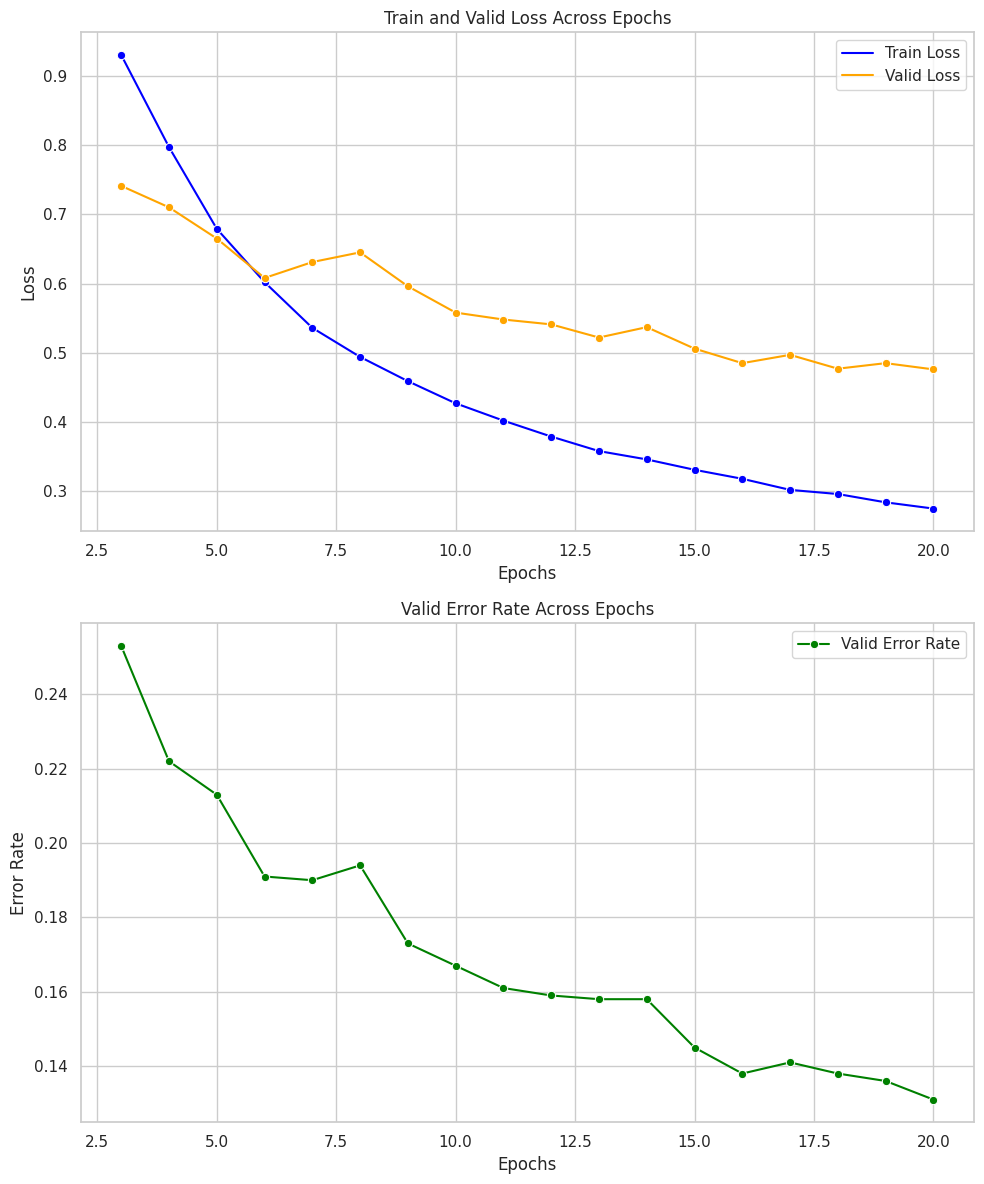

In [14]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Path to the train_log.txt file
log_file_path = "results/enco_dec_Transformer12/1986/train_log.txt"

# Open the train_log.txt file and read its contents
with open(log_file_path, "r") as file:
    log_data = file.read()

# Use regular expressions to extract the data for train loss, valid loss, and valid ErrorRate
data = []
pattern = re.compile(r"epoch: (\d+), .* - train loss: (\d+\.\d+e[-+]\d+) - valid loss: (\d+\.\d+e[-+]\d+), valid ErrorRate: (\d+\.\d+e[-+]\d+)")
matches = pattern.findall(log_data)

for match in matches:
    epoch = int(match[0])
    train_loss = float(match[1])
    valid_loss = float(match[2])
    valid_error_rate = float(match[3])
    data.append((epoch, train_loss, valid_loss, valid_error_rate))

# Create a DataFrame
df = pd.DataFrame(data, columns=["Epochs", "Train Loss", "Valid Loss", "Valid Error Rate"])

# Plot using Seaborn
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot train and valid loss in the first subplot
sns.lineplot(ax=axes[0], x="Epochs", y="value", hue="variable",
             data=pd.melt(df, id_vars=["Epochs"], value_vars=["Train Loss", "Valid Loss"]),
             marker="o", palette={"Train Loss": "blue", "Valid Loss": "orange"})

# Set labels and legend for the first subplot
axes[0].set_title("Train and Valid Loss Across Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend(loc="upper right")

# Plot valid error rate in the second subplot
sns.lineplot(ax=axes[1], x="Epochs", y="Valid Error Rate", data=df, color="green", marker="o", label="Valid Error Rate")

# Set labels and legend for the second subplot
axes[1].set_title("Valid Error Rate Across Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Error Rate")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


### Hparams - Xvector
Encodec with Xvector Model and Xvector classifier

In [25]:
%%file EncoDec_Xvector.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref content/drive/MyDrive/results/enco_dec_Xvector<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/encodec_24khz
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 20
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 24000
shuffle: True

#freeze all ssl
freeze_ssl: True
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
# freeze_ssl_conv: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words
input_shape: 1024
num_workers: 4
num_clusters: 1024
num_codebooks: 16
embedding_dim: 128
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 1024


# Functions
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.encodec.Encodec
    source: !ref <sslmodel_hub>
    sample_rate: !ref <sample_rate>
    bandwidth: 12.0
    freeze: !ref <freeze_ssl>
    flat_embeddings: False
    renorm_embeddings: True
    # freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>


mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False
# Xvector model parameters

#Xvector Model
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <input_shape>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [64, 64, 64, 64, 128]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: !ref <encoder_dim>
    
discrete_embedding_layer: !new:custom_model.Discrete_EmbeddingLayer
   num_codebooks: !ref <num_codebooks>
   vocab_size: !ref <num_clusters>
   emb_dim: !ref <encoder_dim>

attention_mlp: !new:custom_model.AttentionMLP
   input_dim: !ref <encoder_dim>
   hidden_dim: !ref <encoder_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <encoder_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <encoder_dim>
    out_neurons: !ref <out_n_neurons>



log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]


modules:
    ssl_model: !ref <ssl_model>
    embedding_model: !ref <embedding_model>
    discrete_embedding_layer: !ref <discrete_embedding_layer>
    attention_mlp: !ref <attention_mlp>
    classifier: !ref <classifier>
model: !new:torch.nn.ModuleList
    - [!ref <ssl_model>, !ref <discrete_embedding_layer>, !ref <attention_mlp>, !ref <embedding_model> ,!ref <classifier>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting EncoDec_Xvector.yaml


### Train file - Xvector
Train file for Encodec with Xvector model

In [22]:
%%file train_encodec_Xvector.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    Script adapted by David Raby-Pepin 2021
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
import torchaudio
import librosa

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        # Add waveform augmentation if specified.
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            wavs, lens = self.hparams.wav_augment(wavs, lens)
        # print(f' \n computefeature type :{type(self.modules.compute_features)}')
        # if   isinstance(
        #     self.modules.compute_features, speechbrain.lobes.features.Leaf
        # ):
        #     # if leaf, first normalize the wavs before feeding them to leaf
        #     # no normalization is needed after LEAF
        #     feats = self.modules.mean_var_norm(wavs, lens)
        #     feats = self.modules.compute_features(feats)
        # else:
            # Feature extraction and normalization
        feats,_ = self.modules.ssl_model(wavs, lens)
        # print(f'/n feats dtype : {type(feats)}')
        embeddings = self.modules.discrete_embedding_layer(feats)
        # print(f'embedding shape: { embeddings.shape}')
        att_w = self.modules.attention_mlp(embeddings)
        # print(f'att_w shape: { att_w.shape}')
        feats = torch.matmul(att_w.transpose(2, -1), embeddings).squeeze(-2)
        # feats = self.hparams.mean_var_norm(feats, lens)
        embeddings = self.modules.embedding_model(feats, lens)
        embeddings = self.hparams.avg_pool(embeddings,lens)
        predictions = self.modules.classifier(embeddings)
        # print(f'\n\n feature size : {feats.shape}')


        # # Ecapa model uses softmax outside of its classifer
        # if "softmax" in self.modules.keys():
        #     outputs = self.modules.softmax(outputs)

        return predictions, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
        # print(f'command shape :{command.shape}')
        # print(f'/n/n predictions shpae :{predictions.shape} and lens : {lens.shape}')
        # Concatenate labels (due to data augmentation)
        if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
            command = self.hparams.wav_augment.replicate_labels(command)

        # command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command, lens)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command,lens)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration,target_sr=24000):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        if fs != target_sr:
          sig = librosa.resample(sig.numpy(), orig_sr=fs, target_sr=target_sr)
          sig = torch.tensor(sig)

        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_encodec_Xvector.py


#### Results

In [26]:
!python train_encodec_Xvector.py EncoDec_Xvector.yaml --data_folder = /path_to/GSC

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/usr/local/lib/python3.11/dist-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)
speechbrain.lobes.models.huggingface_transformers.huggingface - EncodecModel is frozen.
huggingface_Encodec - Encodec is frozen.
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: content/drive/MyDrive/results/enco_dec_Xvector12/1986
prepare_GSC - Extracting speech_co

## DAC


### Hparams - Simple MLP
 DAC model with a simple linear model

In [ ]:
%%file DAC.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/DAC<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
# sslmodel_hub: facebook/encodec_24khz
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 4
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 16000
shuffle: True

# ssl model parameters
model_type: '16khz'
model_bitrate: '8kbps'
tag: 'latest'
load_pretrained: True

# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>

encoder_dim: 600
# Functions
ssl_model: !new:speechbrain.lobes.models.discrete.dac.DAC
    model_type: !ref <model_type>
    model_bitrate: !ref <model_bitrate>
    tag: !ref <tag>
    load_pretrained: !ref <load_pretrained>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <encoder_dim>
    n_neurons: !ref <out_n_neurons>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Writing DAC.yaml


### Train file - Simple MLP
 Train file for DAC features and a simple linear model

In [ ]:
%%file train_dac.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    Script adapted by David Raby-Pepin 2021
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig
        # print(f'/n size of wavs: {wavs.shape} /n and contents of wavs: {wavs}')
        wavs = wavs.unsqueeze(1)

        # Add waveform augmentation if specified.
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     wavs, lens = self.hparams.wav_augment(wavs, lens)
        # print(f' \n computefeature type :{type(self.modules.compute_features)}')
        # if   isinstance(
        #     self.modules.compute_features, speechbrain.lobes.features.Leaf
        # ):
        #     # if leaf, first normalize the wavs before feeding them to leaf
        #     # no normalization is needed after LEAF
        #     feats = self.modules.mean_var_norm(wavs, lens)
        #     feats = self.modules.compute_features(feats)
        # else:
            # Feature extraction and normalization
        z,codes,latents,_,length = self.modules.ssl_model.encode(wavs)
        # print(f'/n z : {z} \n\n z shape : {z.shape} \n\n z dtype: {type(z)}')
        # print(f'/n codes : {codes} \n\n codes shape : {codes.shape}\n\n codes dtype : {type(codes)}')
        # print(f'/n feats dtype : {type(feats)}')
        # print(f'/n/n feats  : {feats}')
        codes= codes.float()
        feats = self.hparams.mean_var_norm(codes, lens)

        # print(f' \n\nfeats before flatten: {feats.shape} ')

        feats= feats.view(feats.shape[0],-1)
        # print(f' \n\nfeats after flatten: {feats.shape} ')

        feats = self.modules.output_mlp(feats)
        feats = self.hparams.log_softmax(feats)
        # print(f'\n\n feature size : {feats.shape}')


        # # Ecapa model uses softmax outside of its classifer
        # if "softmax" in self.modules.keys():
        #     outputs = self.modules.softmax(outputs)

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
        # print(f'command shape :{command.shape}')
        # print(f'/n/n predictions shpae :{predictions.shape} and lens : {lens.shape}')
        # Concatenate labels (due to data augmentation)
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Writing train_dac.py


#### Results

In [ ]:
!python train_dac.py DAC.yaml --data_folder= /path_to_/GSC

This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/DAC12/1986
prepare_GSC - Extracting speech_commands_v0.02.tar.gz...
noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1: 569MB [00:11, 50.0MB/s]        
Extracting /path_to_/GSC/noise/data.zip to /path_to_/GSC/noise
RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1: 246MB [00:04, 61.0MB/s]          
Extracting /path_to_/GSC/rir/data.zip to /path_to_/GSC/rir
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - Info: ckpt_interval_minute

### Hparams - GRU
 Hparams file for Dac features with GRU model

In [ ]:
%%file DAC_gru.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/DAC_GRU_ <number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
# sslmodel_hub: facebook/encodec_24khz
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 5
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 16000
shuffle: True

# ssl model parameters
model_type: '16khz'
model_bitrate: '8kbps'
tag: 'latest'
load_pretrained: False


# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>
encoder_dim: 31
n_mels: 32
# Functions
ssl_model: !new:speechbrain.lobes.models.discrete.dac.DAC
    model_type: !ref <model_type>
    model_bitrate: !ref <model_bitrate>
    tag: !ref <tag>
    load_pretrained: !ref <load_pretrained>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False


output_rnn: !new:speechbrain.nnet.RNN.GRU
    input_size: !ref <encoder_dim>
    hidden_size: 256
    num_layers: 2
    bidirectional: True

output_linear: !new:speechbrain.nnet.linear.Linear
    input_size: 512  # Hidden size * 2 for bidirectional
    n_neurons: !ref <out_n_neurons>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    output_rnn: !ref <output_rnn>
    output_linear: !ref <output_linear>
model: !new:torch.nn.ModuleList
    - [!ref <ssl_model>, !ref <output_rnn>, !ref <output_linear>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting DAC_gru.yaml


### Train file - GRU
 Train.py for DAC features with GRU model

In [ ]:
%%file train_dac_gru.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    Script adapted by David Raby-Pepin 2021
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig
        # print(f'/n size of wavs: {wavs.shape} /n and contents of wavs: {wavs}')
        wavs = wavs.unsqueeze(1)

        # Add waveform augmentation if specified.
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     wavs, lens = self.hparams.wav_augment(wavs, lens)
        # print(f' \n computefeature type :{type(self.modules.compute_features)}')
        # if   isinstance(
        #     self.modules.compute_features, speechbrain.lobes.features.Leaf
        # ):
        #     # if leaf, first normalize the wavs before feeding them to leaf
        #     # no normalization is needed after LEAF
        #     feats = self.modules.mean_var_norm(wavs, lens)
        #     feats = self.modules.compute_features(feats)
        # else:
            # Feature extraction and normalization
        tokens, emb = self.modules.ssl_model(wavs)
        tokens = tokens.float()
        feats = self.hparams.mean_var_norm(tokens,lens)

        # print(f'/n feats dtype : {type(feats)}')
        # print(f'/n/n feats  : {feats}')
        # print(f' \n\nfeats before flatten: {feats.shape} ')
        rnn_feats, _ = self.modules.output_rnn(feats)
        rnn_feats = self.hparams.avg_pool(rnn_feats, lens)
        batch,_,_= rnn_feats.shape
        rnn_feats= rnn_feats.reshape(batch, -1)


        feats = self.modules.output_linear(rnn_feats)
        feats = self.hparams.log_softmax(feats)

        # print(f'\n\n feature size : {feats.shape}')


        # # Ecapa model uses softmax outside of its classifer
        # if "softmax" in self.modules.keys():
        #     outputs = self.modules.softmax(outputs)

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
        # print(f'command shape :{command.shape}')
        # print(f'/n/n predictions shpae :{predictions.shape} and lens : {lens.shape}')
        # Concatenate labels (due to data augmentation)
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_dac_gru.py


#### Results

In [ ]:
!rm -rf results/DAC_GRU_ 12/1986
!python train_dac_gru.py DAC_gru.yaml --data_folder= /path_to_/GSC

This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
This version of torchaudio is old. SpeechBrain no longer tries using the torchaudio global backend mechanism in recipes, so if you encounter issues, update torchaudio.
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/DAC_GRU_ 12/1986
prepare_GSC - Extracting speech_commands_v0.02.tar.gz...
/path_to_/GSC/noise/data.zip exists. Skipping download
/path_to_/GSC/rir/data.zip exists. Skipping download
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - Gradscaler enabled: False. Using precision: fp32.
speechbrain.core - 78.3M trainable parameters in SpeakerBrain
speechbr

### Hparams - LSTM
Hparams file with LSTM and two linear layers

In [ ]:
%%file DAC_lstm.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/DAC_LSTM<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
# sslmodel_hub: facebook/encodec_24khz
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 5
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001

sample_rate: 16000
shuffle: True

# ssl model parameters
model_type: '16khz'
model_bitrate: '8kbps'
tag: 'latest'
load_pretrained: True


# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>
encoder_dim: 25600
# Functions
ssl_model: !new:speechbrain.lobes.models.discrete.dac.DAC
    model_type: !ref <model_type>
    model_bitrate: !ref <model_bitrate>
    tag: !ref <tag>
    load_pretrained: !ref <load_pretrained>
#LSTM parameters
input_size: 12

lstm: !new:speechbrain.nnet.RNN.LSTM
    input_size: !ref <input_size>  # Define the input size here
    hidden_size: 512  # Define the hidden size of the LSTM
    num_layers: 4  # Define the number of LSTM layers
    bidirectional: False  # Set to True if you want a bidirectional LSTM
    dropout: 0.5  # Define the dropout probability

output_mlp: !new:torch.nn.Sequential
    - !new:torch.nn.Linear
        in_features: !ref <encoder_dim>
        out_features: 1024
        bias: True
    - !new:torch.nn.ReLU
    - !new:torch.nn.Linear
        in_features: 1024
        out_features: !ref <out_n_neurons>
        bias: False


log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

modules:
    ssl_model: !ref <ssl_model>
    lstm: !ref <lstm>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <ssl_model>, !ref <lstm>, !ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting DAC_lstm.yaml


### Train file - LSTM
Train file for DAC with LSTM model

In [ ]:
%%file train_dac_lstm.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    Script adapted by David Raby-Pepin 2021
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig
        # print(f'/n size of wavs: {wavs.shape} /n and contents of wavs: {wavs}')
        wavs = wavs.unsqueeze(1)

        # Add waveform augmentation if specified.
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     wavs, lens = self.hparams.wav_augment(wavs, lens)
        # print(f' \n computefeature type :{type(self.modules.compute_features)}')
        # if   isinstance(
        #     self.modules.compute_features, speechbrain.lobes.features.Leaf
        # ):
        #     # if leaf, first normalize the wavs before feeding them to leaf
        #     # no normalization is needed after LEAF
        #     feats = self.modules.mean_var_norm(wavs, lens)
        #     feats = self.modules.compute_features(feats)
        # else:
            # Feature extraction and normalization
        tokens,emb = self.modules.ssl_model(wavs)
        tokens = tokens.float()
        feats = self.hparams.mean_var_norm(tokens, lens)
        feats = feats.permute(0,2,1)
        # print(f'/n feats dtype : {type(feats)}')
        # print(f'/n/n feats  : {feats}')
        # print(f' \n\nfeats before flatten: {feats.shape} ')
        lstm_feats, _ = self.modules.lstm(feats)
        batch,_,_= lstm_feats.shape
        lstm_feats=lstm_feats.reshape(batch,-1)

        feats = self.modules.output_mlp(lstm_feats)
        feats = self.hparams.log_softmax(feats)

        # print(f'\n\n feature size : {feats.shape}')


        # # Ecapa model uses softmax outside of its classifer
        # if "softmax" in self.modules.keys():
        #     outputs = self.modules.softmax(outputs)

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
        # print(f'command shape :{command.shape}')
        # print(f'/n/n predictions shpae :{predictions.shape} and lens : {lens.shape}')
        # Concatenate labels (due to data augmentation)
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    # sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    # sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_dac_lstm.py


#### Results

In [ ]:
!python train_dac_lstm.py DAC_lstm.yaml --data_folder = /path_to_/GSC

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/DAC_LSTM12/1986
numexpr.utils - NumExpr defaulting to 2 threads.
prepare_GSC - Extracting speech_commands_v0.02.tar.gz...
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - Gradscaler enabled: False. Using precision: fp32.
speechbrain.core - 107.8M trainable parameters in SpeakerBrain
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

### Hparams - CRDNN
 Hparams file with DAC model and CRDNN model


In [ ]:
%%file DAC_CRDNN.yaml

# Basic parameters
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Use 12 for V2 12 task and 35 for V2 35 task
number_of_commands: 12
output_folder: !ref results/DAC_CRDNN<number_of_commands>/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
# sslmodel_hub: facebook/encodec_24khz
sslmodel_folder: !ref <save_folder>/ssl_checkpoint


# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

# Data files
data_folder: !PLACEHOLDER  # e.g. /path/to/GSC
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.
train_annotation: !ref <output_folder>/train.csv
valid_annotation: !ref <output_folder>/valid.csv
test_annotation: !ref <output_folder>/test.csv
noise_annotation: !ref <save_folder>/noise.csv
rir_annotation: !ref <save_folder>/rir.csv

# Percentage of files used for validation and test
validation_percentage: 10
testing_percentage: 10

# Percentage of unknown and silence examples
# (relative to total of known word samples) to include
percentage_unknown: 10 # Set this to 0 for the V2 35 task
percentage_silence: 10 # Set this to 0 for the V2 35 task

skip_prep: False
ckpt_interval_minutes: 15 # save checkpoint every N min

####################### Training Parameters ####################################
number_of_epochs: 5
batch_size: 32
lr: 0.0001
lr_ssl: 0.00001
activation: !name:torch.nn.LeakyReLU
sample_rate: 16000
shuffle: True

# ssl model parameters
model_type: '16khz'
model_bitrate: '8kbps'
tag: 'latest'
load_pretrained: True


# Number of classes (i.e. different commands)
out_n_neurons: !ref <number_of_commands>  #includes core commands & auxiliary words

num_workers: 4
dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: !ref <shuffle>
    num_workers: !ref <num_workers>
# Functions
ssl_model: !new:speechbrain.lobes.models.discrete.dac.DAC
    model_type: !ref <model_type>
    model_bitrate: !ref <model_bitrate>
    tag: !ref <tag>
    load_pretrained: !ref <load_pretrained>

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

#CRDNN Encoder Parameters
encoder_dim: 12
dnn_neurons: 512
# CRDNN Encoder
enc: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, !ref <encoder_dim>]
    activation: !ref <activation>
    dropout: 0.5
    cnn_blocks: 2
    cnn_channels: (128, 256)
    cnn_kernelsize: (3, 3)
    inter_layer_pooling_size: (2, 2)
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: 4
    rnn_class: !name:speechbrain.nnet.RNN.LSTM
    rnn_layers: 4
    rnn_neurons: 1024
    rnn_bidirectional: True
    rnn_re_init: True
    dnn_blocks: 2
    dnn_neurons: !ref <dnn_neurons>
    use_rnnp: False

inp_features: 6144

# Output Linear Layer
output_mlp: !new:torch.nn.Sequential
    - !new:torch.nn.Linear
        in_features: !ref <inp_features>
        out_features: 1024
        bias: True
    - !new:torch.nn.LeakyReLU
    - !new:torch.nn.Linear
        in_features: 1024
        out_features: !ref <out_n_neurons>
        bias: False
# Softmax activation for classification
log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>


# Download and prepare the dataset of noisy sequences for augmentation
prepare_noise_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <NOISE_DATASET_URL>
    dest_folder: !ref <data_folder_noise>
    ext: wav
    csv_file: !ref <noise_annotation>

# Add noise to input signal
snr_low: 0  # Min SNR for noise augmentation
snr_high: 15  # Max SNR for noise augmentation

add_noise: !new:speechbrain.augment.time_domain.AddNoise
    csv_file: !ref <noise_annotation>
    snr_low: !ref <snr_low>
    snr_high: !ref <snr_high>
    noise_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>


# Download and prepare the dataset of room impulse responses for augmentation
prepare_rir_data: !name:speechbrain.augment.preparation.prepare_dataset_from_URL
    URL: !ref <RIR_DATASET_URL>
    dest_folder: !ref <data_folder_rir>
    ext: wav
    csv_file: !ref <rir_annotation>

# Add reverberation to input signal
add_reverb: !new:speechbrain.augment.time_domain.AddReverb
    csv_file: !ref <rir_annotation>
    reverb_sample_rate: !ref <sample_rate>
    clean_sample_rate: !ref <sample_rate>
    num_workers: !ref <num_workers>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

# Augmenter: Combines previously defined augmentations to perform data augmentation
wav_augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    repeat_augment: 1
    shuffle_augmentations: False
    min_augmentations: 4
    max_augmentations: 4
    augment_prob: 1.0
    augmentations: [
        !ref <add_noise>,
        !ref <add_reverb>,
        !ref <drop_freq>,
        !ref <drop_chunk>]



modules:
    ssl_model: !ref <ssl_model>
    enc: !ref <enc>
    output_mlp: !ref <output_mlp>
model: !new:torch.nn.ModuleList
    - [!ref <ssl_model>, !ref <enc>, !ref <output_mlp>]


# Cost + optimization
compute_cost: !name:speechbrain.nnet.losses.nll_loss
# compute_error: !name:speechbrain.nnet.losses.classification_error

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0.000002

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.9
    patient: 0

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

# Logging + checkpoints
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting DAC_CRDNN.yaml


### Train file - CRDNN
Train file for DAC with CRDNN model

In [ ]:
%%file train_dac_CRDNN.py
#!/usr/bin/python3
"""Recipe for training a classifier using the
Google Speech Commands v0.02 Dataset.

To run this recipe, use the following command:
> python train.py {hyperparameter_file}

Using your own hyperparameter file or one of the following:
    hyperparams/xvect.yaml (xvector system)

Author
    * Mirco Ravanelli 2020
    * Hwidong Na 2020
    * Nauman Dawalatabad 2020
    * Sarthak Yadav 2022
    Script adapted by David Raby-Pepin 2021
"""
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
import torchaudio
import librosa

import speechbrain.nnet.CNN
from speechbrain.utils.distributed import run_on_main


class SpeakerBrain(sb.core.Brain):
    """Class for GSC training"
    """

    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + command classifier.
        Data augmentation and environmental corruption are applied to the
        input speech.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig
        # print(f'/n size of wavs: {wavs.shape} /n and contents of wavs: {wavs}')
        wavs = wavs.unsqueeze(1)

        # Add waveform augmentation if specified.
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     wavs, lens = self.hparams.wav_augment(wavs, lens)
        # print(f' \n computefeature type :{type(self.modules.compute_features)}')
        # if   isinstance(
        #     self.modules.compute_features, speechbrain.lobes.features.Leaf
        # ):
        #     # if leaf, first normalize the wavs before feeding them to leaf
        #     # no normalization is needed after LEAF
        #     feats = self.modules.mean_var_norm(wavs, lens)
        #     feats = self.modules.compute_features(feats)
        # else:
            # Feature extraction and normalization
        z, codes, latents, _, length = self.modules.ssl_model.encode(wavs)
        codes = codes.float()
        codes= codes.permute(0,2,1)

        feats = self.hparams.mean_var_norm(codes, lens)
        crdnn_feats = self.modules.enc(feats)
        # print(f'feat size : {crdnn_feats.shape}, \n\n feats : {crdnn_feats}')
        batch,_,_=crdnn_feats.shape
        crdnn_feats = crdnn_feats.reshape(batch, -1)
        # crdnn_feats = crdnn_feats.view(crdnn_feats.size(0), -1)
        feats = self.modules.output_mlp(crdnn_feats)
        feats = self.hparams.log_softmax(feats)

        # print(f'\n\n feature size : {feats.shape}')


        # # Ecapa model uses softmax outside of its classifer
        # if "softmax" in self.modules.keys():
        #     outputs = self.modules.softmax(outputs)

        return feats, lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using command-id as label.
        """
        predictions, lens = predictions
        uttid = batch.id
        command, _ = batch.command_encoded
        # print(f'command shape :{command.shape}')
        # print(f'/n/n predictions shpae :{predictions.shape} and lens : {lens.shape}')
        # Concatenate labels (due to data augmentation)
        # if stage == sb.Stage.TRAIN and hasattr(self.hparams, "wav_augment"):
        #     command = self.hparams.wav_augment.replicate_labels(command)

        command = command.squeeze(1)
        # compute the cost function
        loss = self.hparams.compute_cost(predictions, command)
        # loss = sb.nnet.losses.nll_loss(predictions, command, lens)

        if hasattr(self.hparams.lr_annealing, "on_batch_end"):
            self.hparams.lr_annealing.on_batch_end(self.optimizer)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(uttid, predictions, command)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of an epoch."""
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ErrorRate"] = self.error_metrics.summarize("average")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ErrorRate": stage_stats["ErrorRate"]},
                min_keys=["ErrorRate"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def init_optimizers(self):
      "Initializes the ssl optimizer and model optimizer"
      self.ssl_optimizer = self.hparams.ssl_opt_class(
          self.modules.ssl_model.parameters()
      )
      self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

      if self.checkpointer is not None:
          self.checkpointer.add_recoverable(
              "ssl_opt", self.ssl_optimizer
          )
          self.checkpointer.add_recoverable("optimizer", self.optimizer)

      self.optimizers_dict = {
          "model_optimizer": self.optimizer,
          "ssl_optimizer": self.ssl_optimizer,
      }


def dataio_prep(hparams):
    "Creates the datasets and their data processing pipelines."

    data_folder = hparams["data_folder"]

    # 1. Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_annotation"],
        replacements={"data_root": data_folder},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_annotation"],
        replacements={"data_root": data_folder},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_annotation"],
        replacements={"data_root": data_folder},
    )

    datasets = [train_data, valid_data, test_data]
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "start", "stop", "duration")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav, start, stop, duration):
        start = int(start)
        stop = int(stop)
        num_frames = stop - start
        sig, fs = torchaudio.load(
            wav, num_frames=num_frames, frame_offset=start
        )
        sig = sig.transpose(0, 1).squeeze(1)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("command")
    @sb.utils.data_pipeline.provides("command", "command_encoded")
    def label_pipeline(command):
        yield command
        command_encoded = label_encoder.encode_sequence_torch([command])
        yield command_encoded

    sb.dataio.dataset.add_dynamic_item(datasets, label_pipeline)

    # 3. Fit encoder:
    # Load or compute the label encoder (with multi-GPU DDP support)
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file, from_didatasets=[train_data], output_key="command",
    )

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "command_encoded"]
    )

    return train_data, valid_data, test_data, label_encoder


if __name__ == "__main__":

    # This flag enables the inbuilt cudnn auto-tuner
    torch.backends.cudnn.benchmark = True

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.core.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Dataset prep (parsing GSC and annotation into csv files)
    from prepare_GSC import prepare_GSC

    # Known words for V2 12 and V2 35 sets
    if hparams["number_of_commands"] == 12:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]
    elif hparams["number_of_commands"] == 35:
        words_wanted = [
            "yes",
            "no",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "bed",
            "bird",
            "cat",
            "dog",
            "happy",
            "house",
            "marvin",
            "sheila",
            "tree",
            "wow",
            "backward",
            "forward",
            "follow",
            "learn",
            "visual",
        ]
    else:
        raise ValueError("number_of_commands must be 12 or 35")

    # Data preparation
    run_on_main(
        prepare_GSC,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["output_folder"],
            "validation_percentage": hparams["validation_percentage"],
            "testing_percentage": hparams["testing_percentage"],
            "percentage_unknown": hparams["percentage_unknown"],
            "percentage_silence": hparams["percentage_silence"],
            "words_wanted": words_wanted,
            "skip_prep": hparams["skip_prep"],
        },
    )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

    # Dataset IO prep: creating Dataset objects and proper encodings for phones
    train_data, valid_data, test_data, label_encoder = dataio_prep(hparams)

    # Brain class initialization
    speaker_brain = SpeakerBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # with torch.autograd.detect_anomaly():
    # Training
    speaker_brain.fit(
        speaker_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = speaker_brain.evaluate(
        test_set=test_data,
        min_key="ErrorRate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_dac_CRDNN.py


#### Results

In [ ]:
!python train_dac_CRDNN.py DAC_CRDNN.yaml --data_folder= /path_to_/GSC

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/DAC_CRDNN12/1986
numexpr.utils - NumExpr defaulting to 2 threads.
prepare_GSC - Extracting speech_commands_v0.02.tar.gz...
/path_to_/GSC/noise/data.zip exists. Skipping download
/path_to_/GSC/rir/data.zip exists. Skipping download
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - Gradscaler enabled: False. Using precision: fp32.
speechbrain.core - 173.1M trainable parameters in SpeakerBrain
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that exces